In [ ]:
import telebot
import sqlite3
from telebot import types
import requests
from bs4 import BeautifulSoup

TOKEN = "6898801075:AAGFGEaPfukiQAOGGmh3cbyakKsgEoL3NQU"
bot = telebot.TeleBot(TOKEN)
user_data = {}

# Initialize the database and create a table if it doesn't exist
conn = sqlite3.connect("users.db", check_same_thread=False)
c = conn.cursor()
c.execute(
    """
CREATE TABLE IF NOT EXISTS users (
    chat_id INTEGER PRIMARY KEY,
    username TEXT,
    password TEXT,
    name_student TEXT,
    faculty TEXT,
    specialty TEXT,
    level TEXT,
    education_language TEXT,
    entry_date TEXT,
    graduation_date TEXT
)
"""
)
conn.commit()


@bot.message_handler(commands=["start"])
def send_welcome(message):
    chat_id = message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        main_page(chat_id)
    else:
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Вход", callback_data="login"))
        bot.send_message(chat_id, "Выберите действие:", reply_markup=markup)


@bot.callback_query_handler(func=lambda call: True)
def handle_callback_query(call):
    user_id = call.from_user.id

    if call.data == "login":
        handle_login_callback(call)
    elif call.data in ["confirm", "cancel"]:
        if user_data.get(user_id):
            if call.data == "confirm":
                confirm_registration(call, user_id)
            elif call.data == "cancel":
                cancel_registration(call, user_id)
        else:
            bot.answer_callback_query(call.id, "Session expired, please start again.")
    elif call.data == "profile":
        handle_profile_callback(call)
    elif call.data == "main_page":
        handle_main_page_callback(call)


def handle_login_callback(call):
    bot.reply_to(call.message, "Введите ваш логин для регистрации.")
    bot.register_next_step_handler(call.message, process_username_step)


def process_username_step(message):
    user_id = message.from_user.id
    user_data[user_id] = {"chat_id": user_id, "username": message.text}
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE username = ?", (message.text,))
    existing_user = c.fetchone()

    if existing_user:
        bot.send_message(user_id, "Пользователь с таким именем уже существует!")
        send_welcome(message)
    else:
        bot.reply_to(message, "Теперь введите ваш пароль.")
        bot.register_next_step_handler(message, process_password_step)


def process_password_step(message):
    user_id = message.from_user.id
    user_data[user_id]["password"] = message.text
    url = "https://oldmy.sdu.edu.kz/index.php"
    data = {
        "username": user_data[user_id]["username"],
        "password": message.text,
        "modstring": "",
        "LogIn": " Log in ",
    }

    response = requests.post(url, data=data, verify=False)
    soup = BeautifulSoup(response.text, "html.parser")
    if "incorrect" in soup.text.lower():
        bot.send_message(
            user_id, "Неправильный пароль. Пожалуйста, попробуйте еще раз."
        )
        send_welcome(message)
    else:
        # td_elements = soup.find_all("td", class_="clsTdInfo", style="color:#333")
        # user_data[user_id]["name_student"] = td_elements[1].text.strip()
        # user_data[user_id]["name_advisor"] = td_elements[3].text.strip()
        # user_data[user_id]["majority_student"] = td_elements[5].text.strip()

        login_url = "https://oldmy.sdu.edu.kz/index.php"

        # Perform login request to get cookies
        session = requests.Session()
        login_response = session.post(login_url, data=data, verify=False)

        # Check if login was successful
        if login_response.status_code == 200:
            print("Login successful.")
        else:
            print("Login failed.")
            exit()

        # URL for fetching transcript data
        transcript_url = "https://oldmy.sdu.edu.kz/index.php?mod=transkript"

        # Fetch transcript data using the established session (with cookies)
        transcript_response = session.get(transcript_url)

        # Parse the response HTML using BeautifulSoup
        soup = BeautifulSoup(transcript_response.text, "html.parser")

        user_data[user_id]["username"] = (
            soup.find("td", text="Student №:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["name_student"] = (
            soup.find("td", text="Student Name:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["faculty"] = (
            soup.find("td", text="Faculty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["specialty"] = (
            soup.find("td", text="Specialty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["level"] = (
            soup.find("td", text="Level:").find_next_sibling("td").get_text(strip=True)
        )
        user_data[user_id]["education_language"] = (
            soup.find("td", text="Education Language:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["entry_date"] = (
            soup.find("td", text="Entry Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["graduation_date"] = (
            soup.find("td", text="Graduation Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        keyboard = types.InlineKeyboardMarkup()
        keyboard.row(
            types.InlineKeyboardButton("✅", callback_data="confirm"),
            types.InlineKeyboardButton("❌", callback_data="cancel"),
        )
        bot.send_message(
            message.chat.id,
            f"Подтвердите ваши данные:\nИмя: {user_data[user_id]['name_student']}",
            reply_markup=keyboard,
        )


def confirm_registration(call, user_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute(
        "INSERT INTO users (chat_id, username, password, name_student, faculty, specialty, level, education_language, entry_date, graduation_date) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
        (
            user_data[user_id]["chat_id"],
            user_data[user_id]["username"],
            user_data[user_id]["password"],
            user_data[user_id]["name_student"],
            # user_data[user_id]["majority_student"],
            user_data[user_id]["faculty"],
            user_data[user_id]["specialty"],
            user_data[user_id]["level"],
            user_data[user_id]["education_language"],
            user_data[user_id]["entry_date"],
            user_data[user_id]["graduation_date"],
        ),
    )

    conn.commit()
    bot.send_message(user_id, "Данные успешно сохранены!")
    main_page(call.message.chat.id)


def cancel_registration(call, user_id):
    bot.send_message(user_id, "Пожалуйста, повторите ввод данных.")
    send_welcome(call.message)


def get_student_data_by_chat_id(chat_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE chat_id = ?", (chat_id,))
    student_data = c.fetchone()
    return student_data


def handle_profile_callback(call):
    chat_id = call.message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        bot.send_message(
            chat_id,
            f"Student ID: {student_data[1]}\nPassword: {student_data[2]}\nName Student: {student_data[3]}\nFaculty: {student_data[4]}\nSpecialty: {student_data[5]}\nLevel: {student_data[6]}\nEducation Language: {student_data[7]}\nEntry Date: {student_data[8]}\nGraduation Date: {student_data[9]}",
            reply_markup=keyboard,
        )

    else:
        bot.send_message(chat_id, "У вас нет сохраненных данных профиля.")


def handle_main_page_callback(call):
    main_page(call.message.chat.id)


def main_page(chat_id):
    student_data = get_student_data_by_chat_id(chat_id)
    keyboard = types.InlineKeyboardMarkup()
    keyboard.add(types.InlineKeyboardButton("Profile👤", callback_data="profile"))
    keyboard.add(types.InlineKeyboardButton("Schedule🗓", callback_data="schedule"))
    keyboard.add(types.InlineKeyboardButton("Transcript🗂", callback_data="schedule"))
    bot.send_message(
        chat_id,
        f"Добро пожаловать {student_data[3]}🙌🏻! Чем я могу вам помочь?😇",
        reply_markup=keyboard,
    )


bot.polling()

In [ ]:
import telebot
import sqlite3
from telebot import types
import requests
from bs4 import BeautifulSoup
from transcript import transcript_scrap

TOKEN = "6898801075:AAGFGEaPfukiQAOGGmh3cbyakKsgEoL3NQU"
bot = telebot.TeleBot(TOKEN)
user_data = {}

# Initialize the database and create a table if it doesn't exist
conn = sqlite3.connect("users.db", check_same_thread=False)
c = conn.cursor()
c.execute(
    """
CREATE TABLE IF NOT EXISTS users (
    chat_id INTEGER PRIMARY KEY,
    username TEXT,
    password TEXT,
    name_student TEXT,
    faculty TEXT,
    specialty TEXT,
    level TEXT,
    education_language TEXT,
    entry_date TEXT,
    graduation_date TEXT
)
"""
)
conn.commit()


@bot.message_handler(commands=["start"])
def send_welcome(message):
    chat_id = message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        main_page(chat_id)
    else:
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Вход", callback_data="login"))
        bot.send_message(chat_id, "Выберите действие:", reply_markup=markup)


@bot.callback_query_handler(func=lambda call: call.data == "transcript")
def callback_schedule(call):
    chat_id = call.message.chat.id
    transcript_scrap(chat_id)
    bot.send_message(chat_id, "Обновление Транскрипта")


@bot.callback_query_handler(func=lambda call: True)
def handle_callback_query(call):
    user_id = call.from_user.id

    if call.data == "login":
        handle_login_callback(call)
    elif call.data in ["confirm", "cancel"]:
        if user_data.get(user_id):
            if call.data == "confirm":
                confirm_registration(call, user_id)
            elif call.data == "cancel":
                cancel_registration(call, user_id)
        else:
            bot.answer_callback_query(call.id, "Session expired, please start again.")
    elif call.data == "profile":
        handle_profile_callback(call)
    elif call.data == "main_page":
        handle_main_page_callback(call)


def handle_login_callback(call):
    bot.reply_to(call.message, "Введите ваш логин для регистрации.")
    bot.register_next_step_handler(call.message, process_username_step)


def process_username_step(message):
    user_id = message.from_user.id
    user_data[user_id] = {"chat_id": user_id, "username": message.text}
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE username = ?", (message.text,))
    existing_user = c.fetchone()

    if existing_user:
        bot.send_message(user_id, "Пользователь с таким именем уже существует!")
        send_welcome(message)
    else:
        bot.reply_to(message, "Теперь введите ваш пароль.")
        bot.register_next_step_handler(message, process_password_step)


def process_password_step(message):
    user_id = message.from_user.id
    user_data[user_id]["password"] = message.text
    url = "https://oldmy.sdu.edu.kz/index.php"
    data = {
        "username": user_data[user_id]["username"],
        "password": message.text,
        "modstring": "",
        "LogIn": " Log in ",
    }

    response = requests.post(url, data=data, verify=False)
    soup = BeautifulSoup(response.text, "html.parser")
    if "incorrect" in soup.text.lower():
        bot.send_message(
            user_id, "Неправильный пароль. Пожалуйста, попробуйте еще раз."
        )
        send_welcome(message)
    else:
        # td_elements = soup.find_all("td", class_="clsTdInfo", style="color:#333")
        # user_data[user_id]["name_student"] = td_elements[1].text.strip()
        # user_data[user_id]["name_advisor"] = td_elements[3].text.strip()
        # user_data[user_id]["majority_student"] = td_elements[5].text.strip()

        login_url = "https://oldmy.sdu.edu.kz/index.php"

        # Perform login request to get cookies
        session = requests.Session()
        login_response = session.post(login_url, data=data, verify=False)

        # Check if login was successful
        if login_response.status_code == 200:
            print("Login successful.")
        else:
            print("Login failed.")
            exit()

        # URL for fetching transcript data
        transcript_url = "https://oldmy.sdu.edu.kz/index.php?mod=transkript"

        # Fetch transcript data using the established session (with cookies)
        transcript_response = session.get(transcript_url)

        # Parse the response HTML using BeautifulSoup
        soup = BeautifulSoup(transcript_response.text, "html.parser")

        user_data[user_id]["username"] = (
            soup.find("td", text="Student №:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["name_student"] = (
            soup.find("td", text="Student Name:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["faculty"] = (
            soup.find("td", text="Faculty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["specialty"] = (
            soup.find("td", text="Specialty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["level"] = (
            soup.find("td", text="Level:").find_next_sibling("td").get_text(strip=True)
        )
        user_data[user_id]["education_language"] = (
            soup.find("td", text="Education Language:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["entry_date"] = (
            soup.find("td", text="Entry Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["graduation_date"] = (
            soup.find("td", text="Graduation Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        keyboard = types.InlineKeyboardMarkup()
        keyboard.row(
            types.InlineKeyboardButton("✅", callback_data="confirm"),
            types.InlineKeyboardButton("❌", callback_data="cancel"),
        )
        bot.send_message(
            message.chat.id,
            f"Подтвердите ваши данные:\nИмя: {user_data[user_id]['name_student']}",
            reply_markup=keyboard,
        )


def confirm_registration(call, user_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute(
        "INSERT INTO users (chat_id, username, password, name_student, faculty, specialty, level, education_language, entry_date, graduation_date) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
        (
            user_data[user_id]["chat_id"],
            user_data[user_id]["username"],
            user_data[user_id]["password"],
            user_data[user_id]["name_student"],
            # user_data[user_id]["majority_student"],
            user_data[user_id]["faculty"],
            user_data[user_id]["specialty"],
            user_data[user_id]["level"],
            user_data[user_id]["education_language"],
            user_data[user_id]["entry_date"],
            user_data[user_id]["graduation_date"],
        ),
    )

    conn.commit()
    bot.send_message(user_id, "Данные успешно сохранены!")
    main_page(call.message.chat.id)


def cancel_registration(call, user_id):
    bot.send_message(user_id, "Пожалуйста, повторите ввод данных.")
    send_welcome(call.message)


def get_student_data_by_chat_id(chat_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE chat_id = ?", (chat_id,))
    student_data = c.fetchone()
    return student_data


def handle_profile_callback(call):
    chat_id = call.message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        bot.send_message(
            chat_id,
            f"Student ID: {student_data[1]}\nPassword: {student_data[2]}\nName Student: {student_data[3]}\nFaculty: {student_data[4]}\nSpecialty: {student_data[5]}\nLevel: {student_data[6]}\nEducation Language: {student_data[7]}\nEntry Date: {student_data[8]}\nGraduation Date: {student_data[9]}",
            reply_markup=keyboard,
        )

    else:
        bot.send_message(chat_id, "У вас нет сохраненных данных профиля.")


# @bot.callback_query_handler(func=lambda call: True)
# def handle_callback_query(call):
#     user_id = call.from_user.id


# @bot.callback_query_handler(func=lambda call: call.data == "transcript")
# def callback_schedule(call):
#     chat_id = call.message.chat.id
#     transcript_scrap(chat_id)
#     bot.send_message(chat_id, "Обновление Транскрипта")


def handle_main_page_callback(call):
    main_page(call.message.chat.id)


def main_page(chat_id):
    student_data = get_student_data_by_chat_id(chat_id)
    keyboard = types.InlineKeyboardMarkup()
    keyboard.add(types.InlineKeyboardButton("Profile👤", callback_data="profile"))
    keyboard.add(types.InlineKeyboardButton("Schedule🗓", callback_data="schedule"))
    keyboard.add(types.InlineKeyboardButton("Transcript🗂", callback_data="transcript"))
    bot.send_message(
        chat_id,
        f"Добро пожаловать {student_data[3]}🙌🏻! Чем я могу вам помочь?😇",
        reply_markup=keyboard,
    )


bot.polling()

In [23]:
from transcript import transcript_scrap
import telebot
import sqlite3
from telebot import types
import requests
from bs4 import BeautifulSoup

chat_id = "767413484"
transcript_scrap(chat_id)


{'username': '210109032', 'password': 'Alisher_2004', 'modstring': '', 'LogIn': ' Log in '}


c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.htm

,Academic Year,Course code,Course title,Internal Credit,Credit / ECTS,Grade,Letter Grade,Point,Traditional,Study Program,Study Year,chatID
0,2021 - 2022. 1,MAT 104,Linear Algebra and Analytic Geometry,3,5,96.0,A,4.00,Excellent,1,1,767413484
1,2021 - 2022. 1,MAT 105,Introductory mathematics,2,3,88.0,P,NaN,Pass,1,1,767413484
2,2021 - 2022. 1,MCM 107,Fundamentals of Programming,2,3,93.0,A-,3.67,Excellent,1,1,767413484
3,2021 - 2022. 1,MCM 111,Mathematical analysis 1,3,5,91.0,A-,3.67,Excellent,1,1,767413484
4,2021 - 2022. 1,MDE 131,Turkish Language 1 (А1 level),2,3,87.0,B+,3.33,Good,1,1,767413484
5,2021 - 2022. 1,MDE 141,Physical Education 1,1,2,97.0,A,4.00,Excellent,1,1,767413484
6,2021 - 2022. 1,MDE 160,Community engagement and value based Society 1,1,0,100.0,P,NaN,Pass,1,1,767413484
7,2021 - 2022. 1,MDE 171,Modern History of Kazakhstan,3,5,94.0,A-,3.67,Excellent,1,1,767413484
8,2021 - 2022. 1,MDE 190,Foreign Language 1 (English for Specific Purpo...,3,5,80.0,B,3.00,Good,1,1,767413484
9,2021 - 2022. 2,CSS 108,Programming Technologies and Educational Practice,3,5,90.0,A-,3.67,Excellent,2,1,767413484


In [25]:
df = transcript_scrap(chat_id)
df

{'username': '210109032', 'password': 'Alisher_2004', 'modstring': '', 'LogIn': ' Log in '}


c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.htm

,Academic Year,Course code,Course title,Internal Credit,Credit / ECTS,Grade,Letter Grade,Point,Traditional,Study Program,Study Year,chatID
0,2021 - 2022. 1,MAT 104,Linear Algebra and Analytic Geometry,3,5,96.0,A,4.00,Excellent,1,1,767413484
1,2021 - 2022. 1,MAT 105,Introductory mathematics,2,3,88.0,P,NaN,Pass,1,1,767413484
2,2021 - 2022. 1,MCM 107,Fundamentals of Programming,2,3,93.0,A-,3.67,Excellent,1,1,767413484
3,2021 - 2022. 1,MCM 111,Mathematical analysis 1,3,5,91.0,A-,3.67,Excellent,1,1,767413484
4,2021 - 2022. 1,MDE 131,Turkish Language 1 (А1 level),2,3,87.0,B+,3.33,Good,1,1,767413484
5,2021 - 2022. 1,MDE 141,Physical Education 1,1,2,97.0,A,4.00,Excellent,1,1,767413484
6,2021 - 2022. 1,MDE 160,Community engagement and value based Society 1,1,0,100.0,P,NaN,Pass,1,1,767413484
7,2021 - 2022. 1,MDE 171,Modern History of Kazakhstan,3,5,94.0,A-,3.67,Excellent,1,1,767413484
8,2021 - 2022. 1,MDE 190,Foreign Language 1 (English for Specific Purpo...,3,5,80.0,B,3.00,Good,1,1,767413484
9,2021 - 2022. 2,CSS 108,Programming Technologies and Educational Practice,3,5,90.0,A-,3.67,Excellent,2,1,767413484


In [57]:
import telebot
import sqlite3
from telebot import types
import requests
from bs4 import BeautifulSoup
from transcript import transcript_scrap, transcript_import
from fpdf import FPDF
import os


TOKEN = "6898801075:AAGFGEaPfukiQAOGGmh3cbyakKsgEoL3NQU"
bot = telebot.TeleBot(TOKEN)
user_data = {}

# Initialize the database and create a table if it doesn't exist
conn = sqlite3.connect("users.db", check_same_thread=False)
c = conn.cursor()
c.execute(
    """
CREATE TABLE IF NOT EXISTS users (
    chat_id INTEGER PRIMARY KEY,
    username TEXT,
    password TEXT,
    name_student TEXT,
    faculty TEXT,
    specialty TEXT,
    level TEXT,
    education_language TEXT,
    entry_date TEXT,
    graduation_date TEXT
)
"""
)
conn.commit()




@bot.message_handler(commands=["start"])
def send_welcome(message):
    chat_id = message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        main_page(chat_id)
    else:
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Вход", callback_data="login"))
        bot.send_message(chat_id, "Выберите действие:", reply_markup=markup)







@bot.callback_query_handler(func=lambda call: call.data == "transcript")
def callback_schedule(call):
    chat_id = call.message.chat.id
    df = transcript_scrap(chat_id)
    print(chat_id)
    # bot.send_message(chat_id, "Обновление Транскрипта")

    # Создаем InlineKeyboardMarkup
    keyboard = types.InlineKeyboardMarkup(row_width=2)

    # Добавляем кнопки с названиями
    buttons = [
        types.InlineKeyboardButton("Year of study", callback_data="study_year"),
        types.InlineKeyboardButton("Course code", callback_data="course_code"),
        types.InlineKeyboardButton("Course title", callback_data="course_title"),
        types.InlineKeyboardButton("Grade", callback_data="grade"),
        types.InlineKeyboardButton("Credit / ECTS", callback_data="credit_ects"),
        types.InlineKeyboardButton("Point", callback_data="point"),
    ]

    keyboard.add(*buttons)

    # Отправляем сообщение с клавиатурой
    bot.send_message(
        chat_id, "Выберите параметр для отображения:", reply_markup=keyboard
    )


@bot.callback_query_handler(func=lambda call: call.data == "study_year")
def callback_study_year(call):
    chat_id = call.message.chat.id
    print(chat_id)
    unique_study_year = df["Study Year"].unique()

    keyboard = types.InlineKeyboardMarkup(row_width=1)

    # Add buttons for each unique study year
    for study_year in unique_study_year:
        # Create InlineKeyboardButton for each study year
        button = types.InlineKeyboardButton(
            str(study_year), callback_data=f"study_year_{study_year}"
        )
        # Add the button to the keyboard
        keyboard.add(button)

    # Send message with the keyboard
    bot.send_message(chat_id, "Select a study year:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: call.data.startswith("study_year_"))
def handle_study_year_selection(call):
    chat_id = call.message.chat.id
    study_year = call.data.split("_")[2]

    # Filter the DataFrame based on the selected study year
    filtered_df = df[df["Study Year"] == int(study_year)]

    # Sort the filtered DataFrame
    sorted_df = filtered_df.sort_values(by=["Study Program"])

    # Save the DataFrame to an Excel file
    file_path = f"{chat_id}_transcript_{study_year}.xlsx"
    sorted_df.to_excel(file_path, index=False)

    # Send the Excel file as a document
    with open(file_path, "rb") as file:
        bot.send_document(chat_id, file)

    # Remove the temporary Excel file
    os.remove(file_path)






# @bot.callback_query_handler(func=lambda call: call.data == "1_term")
# def callback_study_year(call):
#     chat_id = call.message.chat.id
#     df = transcript_scrap(chat_id, 1)
#     df =
#     # bot.send_message(chat_id, "Выберите семестр:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: True)
def handle_callback_query(call):
    user_id = call.from_user.id

    if call.data == "login":
        handle_login_callback(call)
    elif call.data in ["confirm", "cancel"]:
        if user_data.get(user_id):
            if call.data == "confirm":
                confirm_registration(call, user_id)
            elif call.data == "cancel":
                cancel_registration(call, user_id)
        else:
            bot.answer_callback_query(call.id, "Session expired, please start again.")
    elif call.data == "profile":
        handle_profile_callback(call)
    elif call.data == "main_page":
        handle_main_page_callback(call)


def handle_login_callback(call):
    bot.reply_to(call.message, "Введите ваш логин для регистрации.")
    bot.register_next_step_handler(call.message, process_username_step)


def process_username_step(message):
    user_id = message.from_user.id
    user_data[user_id] = {"chat_id": user_id, "username": message.text}
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE username = ?", (message.text,))
    existing_user = c.fetchone()

    if existing_user:
        bot.send_message(user_id, "Пользователь с таким именем уже существует!")
        send_welcome(message)
    else:
        bot.reply_to(message, "Теперь введите ваш пароль.")
        bot.register_next_step_handler(message, process_password_step)


def process_password_step(message):
    user_id = message.from_user.id
    user_data[user_id]["password"] = message.text
    url = "https://oldmy.sdu.edu.kz/index.php"
    data = {
        "username": user_data[user_id]["username"],
        "password": message.text,
        "modstring": "",
        "LogIn": " Log in ",
    }

    response = requests.post(url, data=data, verify=False)
    soup = BeautifulSoup(response.text, "html.parser")
    if "incorrect" in soup.text.lower():
        bot.send_message(
            user_id, "Неправильный пароль. Пожалуйста, попробуйте еще раз."
        )
        send_welcome(message)
    else:
        # td_elements = soup.find_all("td", class_="clsTdInfo", style="color:#333")
        # user_data[user_id]["name_student"] = td_elements[1].text.strip()
        # user_data[user_id]["name_advisor"] = td_elements[3].text.strip()
        # user_data[user_id]["majority_student"] = td_elements[5].text.strip()

        login_url = "https://oldmy.sdu.edu.kz/index.php"

        # Perform login request to get cookies
        session = requests.Session()
        login_response = session.post(login_url, data=data, verify=False)

        # Check if login was successful
        if login_response.status_code == 200:
            print("Login successful.")
        else:
            print("Login failed.")
            exit()

        # URL for fetching transcript data
        transcript_url = "https://oldmy.sdu.edu.kz/index.php?mod=transkript"

        # Fetch transcript data using the established session (with cookies)
        transcript_response = session.get(transcript_url)

        # Parse the response HTML using BeautifulSoup
        soup = BeautifulSoup(transcript_response.text, "html.parser")

        user_data[user_id]["username"] = (
            soup.find("td", text="Student №:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["name_student"] = (
            soup.find("td", text="Student Name:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["faculty"] = (
            soup.find("td", text="Faculty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["specialty"] = (
            soup.find("td", text="Specialty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["level"] = (
            soup.find("td", text="Level:").find_next_sibling("td").get_text(strip=True)
        )
        user_data[user_id]["education_language"] = (
            soup.find("td", text="Education Language:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["entry_date"] = (
            soup.find("td", text="Entry Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["graduation_date"] = (
            soup.find("td", text="Graduation Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        keyboard = types.InlineKeyboardMarkup()
        keyboard.row(
            types.InlineKeyboardButton("✅", callback_data="confirm"),
            types.InlineKeyboardButton("❌", callback_data="cancel"),
        )
        bot.send_message(
            message.chat.id,
            f"Подтвердите ваши данные:\nИмя: {user_data[user_id]['name_student']}",
            reply_markup=keyboard,
        )


def confirm_registration(call, user_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute(
        "INSERT INTO users (chat_id, username, password, name_student, faculty, specialty, level, education_language, entry_date, graduation_date) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
        (
            user_data[user_id]["chat_id"],
            user_data[user_id]["username"],
            user_data[user_id]["password"],
            user_data[user_id]["name_student"],
            # user_data[user_id]["majority_student"],
            user_data[user_id]["faculty"],
            user_data[user_id]["specialty"],
            user_data[user_id]["level"],
            user_data[user_id]["education_language"],
            user_data[user_id]["entry_date"],
            user_data[user_id]["graduation_date"],
        ),
    )

    conn.commit()
    bot.send_message(user_id, "Данные успешно сохранены!")
    main_page(call.message.chat.id)


def cancel_registration(call, user_id):
    bot.send_message(user_id, "Пожалуйста, повторите ввод данных.")
    send_welcome(call.message)


def get_student_data_by_chat_id(chat_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE chat_id = ?", (chat_id,))
    student_data = c.fetchone()
    return student_data


def handle_profile_callback(call):
    chat_id = call.message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        bot.send_message(
            chat_id,
            f"Student ID: {student_data[1]}\nPassword: {student_data[2]}\nName Student: {student_data[3]}\nFaculty: {student_data[4]}\nSpecialty: {student_data[5]}\nLevel: {student_data[6]}\nEducation Language: {student_data[7]}\nEntry Date: {student_data[8]}\nGraduation Date: {student_data[9]}",
            reply_markup=keyboard,
        )

    else:
        bot.send_message(chat_id, "У вас нет сохраненных данных профиля.")

def handle_main_page_callback(call):
    main_page(call.message.chat.id)


def main_page(chat_id):
    student_data = get_student_data_by_chat_id(chat_id)
    keyboard = types.InlineKeyboardMarkup()
    keyboard.add(types.InlineKeyboardButton("Profile👤", callback_data="profile"))
    keyboard.add(types.InlineKeyboardButton("Schedule🗓", callback_data="schedule"))
    keyboard.add(types.InlineKeyboardButton("Transcript🗂", callback_data="transcript"))
    bot.send_message(
        chat_id,
        f"Добро пожаловать {student_data[3]}🙌🏻! Чем я могу вам помочь?😇",
        reply_markup=keyboard,
    )


bot.polling()

767413484


In [7]:
import telebot
import sqlite3
from telebot import types
import requests
from bs4 import BeautifulSoup
from transcript import transcript_scrap, transcript_import
from fpdf import FPDF
import os


TOKEN = "6898801075:AAGFGEaPfukiQAOGGmh3cbyakKsgEoL3NQU"
bot = telebot.TeleBot(TOKEN)
user_data = {}

# Initialize the database and create a table if it doesn't exist
conn = sqlite3.connect("users.db", check_same_thread=False)
c = conn.cursor()
c.execute(
    """
CREATE TABLE IF NOT EXISTS users (
    chat_id INTEGER PRIMARY KEY,
    username TEXT,
    password TEXT,
    name_student TEXT,
    faculty TEXT,
    specialty TEXT,
    level TEXT,
    education_language TEXT,
    entry_date TEXT,
    graduation_date TEXT
)
"""
)
conn.commit()


@bot.message_handler(commands=["start"])
def send_welcome(message):
    chat_id = message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        main_page(chat_id)
    else:
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Вход", callback_data="login"))
        bot.send_message(chat_id, "Выберите действие:", reply_markup=markup)


@bot.callback_query_handler(func=lambda call: call.data == "transcript")
def callback_schedule(call):
    chat_id = call.message.chat.id
    print(chat_id)
    # bot.send_message(chat_id, "Обновление Транскрипта")

    # Создаем InlineKeyboardMarkup
    keyboard = types.InlineKeyboardMarkup(row_width=2)

    # Добавляем кнопки с названиями
    buttons = [
        types.InlineKeyboardButton("Year of study", callback_data="study_year"),
        types.InlineKeyboardButton("Course code", callback_data="course_code"),
        types.InlineKeyboardButton("Course title", callback_data="course_title"),
        types.InlineKeyboardButton("Grade", callback_data="grade"),
        types.InlineKeyboardButton("Credit / ECTS", callback_data="credit_ects"),
        types.InlineKeyboardButton("Point", callback_data="point"),
    ]

    keyboard.add(*buttons)

    # Отправляем сообщение с клавиатурой
    bot.send_message(
        chat_id, "Выберите параметр для отображения:", reply_markup=keyboard
    )


@bot.callback_query_handler(func=lambda call: call.data == "study_year")
def callback_study_year(call):
    chat_id = call.message.chat.id
    print(chat_id)
    df = transcript_scrap(chat_id)
    unique_study_year = df["Study Year"].unique()

    keyboard = types.InlineKeyboardMarkup(row_width=1)

    # Add buttons for each unique study year
    for study_year in unique_study_year:
        # Create InlineKeyboardButton for each study year
        button = types.InlineKeyboardButton(
            str(study_year), callback_data=f"study_year_{study_year}"
        )
        # Add the button to the keyboard
        keyboard.add(button)

    # Send message with the keyboard
    bot.send_message(chat_id, "Select a study year:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: call.data.startswith("study_year_"))
def handle_study_year_selection(call):
    chat_id = call.message.chat.id
    df = transcript_import(chat_id)
    print(chat_id)
    print(df)
    study_year = call.data.split("_")[2]

    # Filter the DataFrame based on the selected study year
    filtered_df = df[df["Study Year"] == int(study_year)]
    filtered_df = filtered_df.drop(columns=["chatID"])  

    # Sort the filtered DataFrame
    sorted_df = filtered_df.sort_values(by=["Study Program"])
    

    # Save the DataFrame to an Excel file
    file_path = f"{chat_id}_transcript_{study_year}.xlsx"
    sorted_df.to_excel(file_path, index=False)

    # Send the Excel file as a document
    with open(file_path, "rb") as file:
        bot.send_document(chat_id, file)

    # Remove the temporary Excel file
    os.remove(file_path)


# @bot.callback_query_handler(func=lambda call: call.data == "1_term")
# def callback_study_year(call):
#     chat_id = call.message.chat.id
#     df = transcript_scrap(chat_id, 1)
#     df =
#     # bot.send_message(chat_id, "Выберите семестр:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: True)
def handle_callback_query(call):
    user_id = call.from_user.id

    if call.data == "login":
        handle_login_callback(call)
    elif call.data in ["confirm", "cancel"]:
        if user_data.get(user_id):
            if call.data == "confirm":
                confirm_registration(call, user_id)
            elif call.data == "cancel":
                cancel_registration(call, user_id)
        else:
            bot.answer_callback_query(call.id, "Session expired, please start again.")
    elif call.data == "profile":
        handle_profile_callback(call)
    elif call.data == "main_page":
        handle_main_page_callback(call)


def handle_login_callback(call):
    bot.reply_to(call.message, "Введите ваш логин для регистрации.")
    bot.register_next_step_handler(call.message, process_username_step)


def process_username_step(message):
    user_id = message.from_user.id
    user_data[user_id] = {"chat_id": user_id, "username": message.text}
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE username = ?", (message.text,))
    existing_user = c.fetchone()

    if existing_user:
        bot.send_message(user_id, "Пользователь с таким именем уже существует!")
        send_welcome(message)
    else:
        bot.reply_to(message, "Теперь введите ваш пароль.")
        bot.register_next_step_handler(message, process_password_step)


def process_password_step(message):
    user_id = message.from_user.id
    user_data[user_id]["password"] = message.text
    url = "https://oldmy.sdu.edu.kz/index.php"
    data = {
        "username": user_data[user_id]["username"],
        "password": message.text,
        "modstring": "",
        "LogIn": " Log in ",
    }

    response = requests.post(url, data=data, verify=False)
    soup = BeautifulSoup(response.text, "html.parser")
    if "incorrect" in soup.text.lower():
        bot.send_message(
            user_id, "Неправильный пароль. Пожалуйста, попробуйте еще раз."
        )
        send_welcome(message)
    else:
        # td_elements = soup.find_all("td", class_="clsTdInfo", style="color:#333")
        # user_data[user_id]["name_student"] = td_elements[1].text.strip()
        # user_data[user_id]["name_advisor"] = td_elements[3].text.strip()
        # user_data[user_id]["majority_student"] = td_elements[5].text.strip()

        login_url = "https://oldmy.sdu.edu.kz/index.php"

        # Perform login request to get cookies
        session = requests.Session()
        login_response = session.post(login_url, data=data, verify=False)

        # Check if login was successful
        if login_response.status_code == 200:
            print("Login successful.")
        else:
            print("Login failed.")
            exit()

        # URL for fetching transcript data
        transcript_url = "https://oldmy.sdu.edu.kz/index.php?mod=transkript"

        # Fetch transcript data using the established session (with cookies)
        transcript_response = session.get(transcript_url)

        # Parse the response HTML using BeautifulSoup
        soup = BeautifulSoup(transcript_response.text, "html.parser")

        user_data[user_id]["username"] = (
            soup.find("td", text="Student №:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["name_student"] = (
            soup.find("td", text="Student Name:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["faculty"] = (
            soup.find("td", text="Faculty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["specialty"] = (
            soup.find("td", text="Specialty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["level"] = (
            soup.find("td", text="Level:").find_next_sibling("td").get_text(strip=True)
        )
        user_data[user_id]["education_language"] = (
            soup.find("td", text="Education Language:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["entry_date"] = (
            soup.find("td", text="Entry Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["graduation_date"] = (
            soup.find("td", text="Graduation Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        keyboard = types.InlineKeyboardMarkup()
        keyboard.row(
            types.InlineKeyboardButton("✅", callback_data="confirm"),
            types.InlineKeyboardButton("❌", callback_data="cancel"),
        )
        bot.send_message(
            message.chat.id,
            f"Подтвердите ваши данные:\nИмя: {user_data[user_id]['name_student']}",
            reply_markup=keyboard,
        )


def confirm_registration(call, user_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute(
        "INSERT INTO users (chat_id, username, password, name_student, faculty, specialty, level, education_language, entry_date, graduation_date) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
        (
            user_data[user_id]["chat_id"],
            user_data[user_id]["username"],
            user_data[user_id]["password"],
            user_data[user_id]["name_student"],
            # user_data[user_id]["majority_student"],
            user_data[user_id]["faculty"],
            user_data[user_id]["specialty"],
            user_data[user_id]["level"],
            user_data[user_id]["education_language"],
            user_data[user_id]["entry_date"],
            user_data[user_id]["graduation_date"],
        ),
    )

    conn.commit()
    bot.send_message(user_id, "Данные успешно сохранены!")
    main_page(call.message.chat.id)


def cancel_registration(call, user_id):
    bot.send_message(user_id, "Пожалуйста, повторите ввод данных.")
    send_welcome(call.message)


def get_student_data_by_chat_id(chat_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE chat_id = ?", (chat_id,))
    student_data = c.fetchone()
    return student_data


def handle_profile_callback(call):
    chat_id = call.message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        bot.send_message(
            chat_id,
            f"Student ID: {student_data[1]}\nPassword: {student_data[2]}\nName Student: {student_data[3]}\nFaculty: {student_data[4]}\nSpecialty: {student_data[5]}\nLevel: {student_data[6]}\nEducation Language: {student_data[7]}\nEntry Date: {student_data[8]}\nGraduation Date: {student_data[9]}",
            reply_markup=keyboard,
        )

    else:
        bot.send_message(chat_id, "У вас нет сохраненных данных профиля.")

def handle_main_page_callback(call):
    main_page(call.message.chat.id)


def main_page(chat_id):
    student_data = get_student_data_by_chat_id(chat_id)
    keyboard = types.InlineKeyboardMarkup()
    keyboard.add(types.InlineKeyboardButton("Profile👤", callback_data="profile"))
    keyboard.add(types.InlineKeyboardButton("Schedule🗓", callback_data="schedule"))
    keyboard.add(types.InlineKeyboardButton("Transcript🗂", callback_data="transcript"))
    bot.send_message(
        chat_id,
        f"Добро пожаловать {student_data[3]}🙌🏻! Чем я могу вам помочь?😇",
        reply_markup=keyboard,
    )


bot.polling()

686968209
686968209
{'username': '210107120', 'password': 'agytai200four', 'modstring': '', 'LogIn': ' Log in '}


c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.htm

686968209
     Academic Year Course code  \
0   2021 - 2022. 1     CSS 105   
1   2021 - 2022. 1     MAT 151   
2   2021 - 2022. 1     MAT 153   
3   2021 - 2022. 1     MDE 131   
4   2021 - 2022. 1     MDE 141   
5   2021 - 2022. 1     MDE 161   
6   2021 - 2022. 1     MDE 190   
7   2021 - 2022. 2     CSS 108   
8   2021 - 2022. 2     INF 106   
9   2021 - 2022. 2     MAT 154   
10  2021 - 2022. 2     MAT 156   
11  2021 - 2022. 2     MDE 132   
12  2021 - 2022. 2     MDE 142   
13  2021 - 2022. 2     MDE 191   
14  2022 - 2023. 1     CSS 152   
15  2022 - 2023. 1     CSS 206   
16  2022 - 2023. 1     CSS 215   
17  2022 - 2023. 1     CSS 252   
18  2022 - 2023. 1     MDE 125   
19  2022 - 2023. 1     MDE 133   
20  2022 - 2023. 1     MDE 152   
21  2022 - 2023. 1     MDE 171   
22  2022 - 2023. 1     MDE 279   
23  2022 - 2023. 2     CSS 254   
24  2022 - 2023. 2     CSS 356   
25  2022 - 2023. 2     MAT 251   
26  2022 - 2023. 2     MDE 126   
27  2022 - 2023. 2     MDE 134   
28  

In [5]:
import telebot
import sqlite3
from telebot import types
import requests
from bs4 import BeautifulSoup
from transcript import transcript_scrap, transcript_import
from GPA_plot import gpa_plot
from fpdf import FPDF
import os


TOKEN = "6898801075:AAGFGEaPfukiQAOGGmh3cbyakKsgEoL3NQU"
bot = telebot.TeleBot(TOKEN)
user_data = {}

# Initialize the database and create a table if it doesn't exist
conn = sqlite3.connect("users.db", check_same_thread=False)
c = conn.cursor()
c.execute(
    """
CREATE TABLE IF NOT EXISTS users (
    chat_id INTEGER PRIMARY KEY,
    username TEXT,
    password TEXT,
    name_student TEXT,
    faculty TEXT,
    specialty TEXT,
    level TEXT,
    education_language TEXT,
    entry_date TEXT,
    graduation_date TEXT
)
"""
)
conn.commit()


@bot.message_handler(commands=["start"])
def send_welcome(message):
    chat_id = message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        main_page(chat_id)
    else:
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Вход", callback_data="login"))
        bot.send_message(chat_id, "Выберите действие:", reply_markup=markup)


@bot.callback_query_handler(func=lambda call: call.data == "transcript")
def callback_schedule(call):
    chat_id = call.message.chat.id
    print(chat_id)
    # bot.send_message(chat_id, "Обновление Транскрипта")

    # Создаем InlineKeyboardMarkup
    keyboard = types.InlineKeyboardMarkup(row_width=2)

    # Добавляем кнопки с названиями
    buttons = [
        types.InlineKeyboardButton("Year of study", callback_data="study_year"),
        types.InlineKeyboardButton("GPA Statistics", callback_data="gpa_tatistics"),
        types.InlineKeyboardButton("Course title", callback_data="course_title"),
        types.InlineKeyboardButton("Grade", callback_data="grade"),
        types.InlineKeyboardButton("Credit / ECTS", callback_data="credit_ects"),
        types.InlineKeyboardButton("Point", callback_data="point"),
    ]

    keyboard.add(*buttons)

    # Отправляем сообщение с клавиатурой
    bot.send_message(
        chat_id, "Выберите параметр для отображения:", reply_markup=keyboard
    )


@bot.callback_query_handler(func=lambda call: call.data == "study_year")
def callback_study_year(call):
    chat_id = call.message.chat.id
    print(chat_id)
    df = transcript_scrap(chat_id)
    unique_study_year = df["Study Year"].unique()

    keyboard = types.InlineKeyboardMarkup(row_width=1)

    # Add buttons for each unique study year
    for study_year in unique_study_year:
        # Create InlineKeyboardButton for each study year
        button = types.InlineKeyboardButton(
            str(study_year), callback_data=f"study_year_{study_year}"
        )
        # Add the button to the keyboard
        keyboard.add(button)

    # Send message with the keyboard
    bot.send_message(chat_id, "Select a study year:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: call.data.startswith("study_year_"))
def handle_study_year_selection(call):
    chat_id = call.message.chat.id
    df = transcript_import(chat_id)
    print(chat_id)
    print(df)
    study_year = call.data.split("_")[2]

    # Filter the DataFrame based on the selected study year
    filtered_df = df[df["Study Year"] == int(study_year)]
    filtered_df = filtered_df.drop(columns=["chatID"])

    # Sort the filtered DataFrame
    sorted_df = filtered_df.sort_values(by=["Study Program"])

    # Save the DataFrame to an Excel file
    file_path = f"{chat_id}_transcript_{study_year}.xlsx"
    sorted_df.to_excel(file_path, index=False)

    # Send the Excel file as a document
    with open(file_path, "rb") as file:
        bot.send_document(chat_id, file)

    # Remove the temporary Excel file
    os.remove(file_path)


@bot.callback_query_handler(func=lambda call: call.data == "gpa_tatistics")
def callback_study_year(call):
    chat_id = call.message.chat.id
    filename = gpa_plot(chat_id)
    try:
        with open(filename, "rb") as file:
            bot.send_photo(chat_id, file)  # Changed from send_document to send_photo
    finally:
        if os.path.exists(filename):
            # os.remove(filename)  # Uncommented this line to actually delete the file
            print(f"File {filename} has been deleted.")


# @bot.callback_query_handler(func=lambda call: call.data == "1_term")
# def callback_study_year(call):
#     chat_id = call.message.chat.id
#     df = transcript_scrap(chat_id, 1)
#     df =
#     # bot.send_message(chat_id, "Выберите семестр:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: True)
def handle_callback_query(call):
    user_id = call.from_user.id

    if call.data == "login":
        handle_login_callback(call)
    elif call.data in ["confirm", "cancel"]:
        if user_data.get(user_id):
            if call.data == "confirm":
                confirm_registration(call, user_id)
            elif call.data == "cancel":
                cancel_registration(call, user_id)
        else:
            bot.answer_callback_query(call.id, "Session expired, please start again.")
    elif call.data == "profile":
        handle_profile_callback(call)
    elif call.data == "main_page":
        handle_main_page_callback(call)


def handle_login_callback(call):
    bot.reply_to(call.message, "Введите ваш логин для регистрации.")
    bot.register_next_step_handler(call.message, process_username_step)


def process_username_step(message):
    user_id = message.from_user.id
    user_data[user_id] = {"chat_id": user_id, "username": message.text}
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE username = ?", (message.text,))
    existing_user = c.fetchone()

    if existing_user:
        bot.send_message(user_id, "Пользователь с таким именем уже существует!")
        send_welcome(message)
    else:
        bot.reply_to(message, "Теперь введите ваш пароль.")
        bot.register_next_step_handler(message, process_password_step)


def process_password_step(message):
    user_id = message.from_user.id
    user_data[user_id]["password"] = message.text
    url = "https://oldmy.sdu.edu.kz/index.php"
    data = {
        "username": user_data[user_id]["username"],
        "password": message.text,
        "modstring": "",
        "LogIn": " Log in ",
    }

    response = requests.post(url, data=data, verify=False)
    soup = BeautifulSoup(response.text, "html.parser")
    if "incorrect" in soup.text.lower():
        bot.send_message(
            user_id, "Неправильный пароль. Пожалуйста, попробуйте еще раз."
        )
        send_welcome(message)
    else:
        # td_elements = soup.find_all("td", class_="clsTdInfo", style="color:#333")
        # user_data[user_id]["name_student"] = td_elements[1].text.strip()
        # user_data[user_id]["name_advisor"] = td_elements[3].text.strip()
        # user_data[user_id]["majority_student"] = td_elements[5].text.strip()

        login_url = "https://oldmy.sdu.edu.kz/index.php"

        # Perform login request to get cookies
        session = requests.Session()
        login_response = session.post(login_url, data=data, verify=False)

        # Check if login was successful
        if login_response.status_code == 200:
            print("Login successful.")
        else:
            print("Login failed.")
            exit()

        # URL for fetching transcript data
        transcript_url = "https://oldmy.sdu.edu.kz/index.php?mod=transkript"

        # Fetch transcript data using the established session (with cookies)
        transcript_response = session.get(transcript_url)

        # Parse the response HTML using BeautifulSoup
        soup = BeautifulSoup(transcript_response.text, "html.parser")

        user_data[user_id]["username"] = (
            soup.find("td", text="Student №:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["name_student"] = (
            soup.find("td", text="Student Name:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["faculty"] = (
            soup.find("td", text="Faculty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["specialty"] = (
            soup.find("td", text="Specialty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["level"] = (
            soup.find("td", text="Level:").find_next_sibling("td").get_text(strip=True)
        )
        user_data[user_id]["education_language"] = (
            soup.find("td", text="Education Language:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["entry_date"] = (
            soup.find("td", text="Entry Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["graduation_date"] = (
            soup.find("td", text="Graduation Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        keyboard = types.InlineKeyboardMarkup()
        keyboard.row(
            types.InlineKeyboardButton("✅", callback_data="confirm"),
            types.InlineKeyboardButton("❌", callback_data="cancel"),
        )
        bot.send_message(
            message.chat.id,
            f"Подтвердите ваши данные:\nИмя: {user_data[user_id]['name_student']}",
            reply_markup=keyboard,
        )


def confirm_registration(call, user_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute(
        "INSERT INTO users (chat_id, username, password, name_student, faculty, specialty, level, education_language, entry_date, graduation_date) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
        (
            user_data[user_id]["chat_id"],
            user_data[user_id]["username"],
            user_data[user_id]["password"],
            user_data[user_id]["name_student"],
            # user_data[user_id]["majority_student"],
            user_data[user_id]["faculty"],
            user_data[user_id]["specialty"],
            user_data[user_id]["level"],
            user_data[user_id]["education_language"],
            user_data[user_id]["entry_date"],
            user_data[user_id]["graduation_date"],
        ),
    )

    conn.commit()
    bot.send_message(user_id, "Данные успешно сохранены!")
    main_page(call.message.chat.id)


def cancel_registration(call, user_id):
    bot.send_message(user_id, "Пожалуйста, повторите ввод данных.")
    send_welcome(call.message)


def get_student_data_by_chat_id(chat_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE chat_id = ?", (chat_id,))
    student_data = c.fetchone()
    return student_data


def handle_profile_callback(call):
    chat_id = call.message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        bot.send_message(
            chat_id,
            f"Student ID: {student_data[1]}\nPassword: {student_data[2]}\nName Student: {student_data[3]}\nFaculty: {student_data[4]}\nSpecialty: {student_data[5]}\nLevel: {student_data[6]}\nEducation Language: {student_data[7]}\nEntry Date: {student_data[8]}\nGraduation Date: {student_data[9]}",
            reply_markup=keyboard,
        )

    else:
        bot.send_message(chat_id, "У вас нет сохраненных данных профиля.")


def handle_main_page_callback(call):
    main_page(call.message.chat.id)


def main_page(chat_id):
    student_data = get_student_data_by_chat_id(chat_id)
    keyboard = types.InlineKeyboardMarkup()
    keyboard.add(types.InlineKeyboardButton("Profile👤", callback_data="profile"))
    keyboard.add(types.InlineKeyboardButton("Schedule🗓", callback_data="schedule"))
    keyboard.add(types.InlineKeyboardButton("Transcript🗂", callback_data="transcript"))
    bot.send_message(
        chat_id,
        f"Добро пожаловать {student_data[3]}🙌🏻! Чем я могу вам помочь?😇",
        reply_markup=keyboard,
    )


bot.polling()

{'username': '210109032', 'password': 'Alisher_2004', 'modstring': '', 'LogIn': ' Log in '}


c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\Рабочий стол\hackathon\GPA_plot.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Weighted_Points"] = df_cleaned["Point"] * df_cleaned["Credit / ECTS"]


File 767413484_GPA.png has been deleted.
{'username': '210109032', 'password': 'Alisher_2004', 'modstring': '', 'LogIn': ' Log in '}


c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\Рабочий стол\hackathon\GPA_plot.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Weighted_Points"] = df_cleaned["Point"] * df_cleaned["Credit / ECTS"]


File 767413484_GPA.png has been deleted.


In [9]:
import telebot
import sqlite3
from telebot import types
import requests
from bs4 import BeautifulSoup
from transcript import transcript_scrap, transcript_import
from GPA_plot import gpa_plot
from fpdf import FPDF
import os


TOKEN = "6898801075:AAGFGEaPfukiQAOGGmh3cbyakKsgEoL3NQU"
bot = telebot.TeleBot(TOKEN)
user_data = {}

# Initialize the database and create a table if it doesn't exist
conn = sqlite3.connect("users.db", check_same_thread=False)
c = conn.cursor()
c.execute(
    """
CREATE TABLE IF NOT EXISTS users (
    chat_id INTEGER PRIMARY KEY,
    username TEXT,
    password TEXT,
    name_student TEXT,
    faculty TEXT,
    specialty TEXT,
    level TEXT,
    education_language TEXT,
    entry_date TEXT,
    graduation_date TEXT
)
"""
)
conn.commit()


@bot.message_handler(commands=["start"])
def send_welcome(message):
    chat_id = message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        main_page(chat_id)
    else:
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Log in", callback_data="login"))
        bot.send_message(
            chat_id,
            "Hi! 👋 I am your personal AI Advisor by SDU University for studying 📚🤖.\nClick on the 'Log in' button, and let's immerse ourselves in the world of your studies! 🚀",
            reply_markup=markup,
        )


@bot.callback_query_handler(func=lambda call: call.data == "transcript")
def callback_schedule(call):
    chat_id = call.message.chat.id
    print(chat_id)
    # bot.send_message(chat_id, "Обновление Транскрипта")

    # Создаем InlineKeyboardMarkup
    keyboard = types.InlineKeyboardMarkup(row_width=2)

    # Добавляем кнопки с названиями
    buttons = [
        types.InlineKeyboardButton("Year of study", callback_data="study_year"),
        types.InlineKeyboardButton("GPA Statistics", callback_data="gpa_statistics"),
        types.InlineKeyboardButton("Course title", callback_data="course_title"),
        types.InlineKeyboardButton("Grade", callback_data="grade"),
        types.InlineKeyboardButton("Credit / ECTS", callback_data="credit_ects"),
        types.InlineKeyboardButton("Point", callback_data="point"),
    ]

    keyboard.add(*buttons)

    # Отправляем сообщение с клавиатурой
    bot.send_message(chat_id, "Select an option to display:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: call.data == "study_year")
def callback_study_year(call):
    chat_id = call.message.chat.id
    print(chat_id)
    df = transcript_scrap(chat_id)
    unique_study_year = df["Study Year"].unique()
    keyboard = types.InlineKeyboardMarkup(row_width=1)
    for study_year in unique_study_year:
        button = types.InlineKeyboardButton(
            str(study_year), callback_data=f"study_year_{study_year}"
        )
        keyboard.add(button)
    # Add a button for all study years
    keyboard.add(
        types.InlineKeyboardButton("All Study Years", callback_data="study_year_all")
    )

    bot.send_message(chat_id, "Select a study year:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: call.data.startswith("study_year_"))
def handle_study_year_selection(call):
    chat_id = call.message.chat.id
    df = transcript_import(chat_id)
    df.drop(columns=["chatID"], inplace=True)  # Delete the "chatID" column
    print(chat_id)
    print(df)
    study_year = call.data.split("_")[2]

    transcripts_folder = "Transcripts"
    if not os.path.exists(transcripts_folder):
        os.makedirs(transcripts_folder)

    if study_year == "all":
        # Send the original DataFrame without filtering
        file_path = os.path.join(transcripts_folder, f"{chat_id}_transcript_all.xlsx")
        df.to_excel(file_path, index=False)
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        with open(file_path, "rb") as file:
            bot.send_document(chat_id, file, reply_markup=keyboard)
    else:
        filtered_df = df[df["Study Year"] == int(study_year)]
        filtered_df = filtered_df.drop(columns=["chatID"])
        sorted_df = filtered_df.sort_values(by=["Study Program"])

        file_path = os.path.join(
            transcripts_folder, f"{chat_id}_transcript_{study_year}.xlsx"
        )
        sorted_df.to_excel(file_path, index=False)

        # Add a button for all study years
        keyboard_all = types.InlineKeyboardMarkup()
        keyboard_all.add(
            types.InlineKeyboardButton(
                "All Study Years", callback_data="study_year_all"
            )
        )

        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        with open(file_path, "rb") as file:
            bot.send_document(chat_id, file, reply_markup=keyboard)
            bot.send_message(
                chat_id, "Please select a study year:", reply_markup=keyboard_all
            )


# os.remove(file_path)


@bot.callback_query_handler(func=lambda call: call.data == "gpa_statistics")
def callback_study_year(call):
    chat_id = call.message.chat.id
    filename = gpa_plot(chat_id)
    try:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        with open(filename, "rb") as file:
            bot.send_photo(
                chat_id, file, reply_markup=keyboard
            )  # Changed from send_document to send_photo
    finally:
        if os.path.exists(filename):
            print(f"File {filename} has been deleted.")


# @bot.callback_query_handler(func=lambda call: call.data == "1_term")
# def callback_study_year(call):
#     chat_id = call.message.chat.id
#     df = transcript_scrap(chat_id, 1)
#     df =
#     # bot.send_message(chat_id, "Выберите семестр:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: True)
def handle_callback_query(call):
    user_id = call.from_user.id

    if call.data == "login":
        handle_login_callback(call)
    elif call.data in ["confirm", "cancel"]:
        if user_data.get(user_id):
            if call.data == "confirm":
                confirm_registration(call, user_id)
            elif call.data == "cancel":
                cancel_registration(call, user_id)
        else:
            bot.answer_callback_query(call.id, "Session expired, please start again.")
    elif call.data == "profile":
        handle_profile_callback(call)
    elif call.data == "main_page":
        handle_main_page_callback(call)


def handle_login_callback(call):
    bot.reply_to(call.message, "Enter your Student number from oldmy.sdu.edu.kz")
    bot.register_next_step_handler(call.message, process_username_step)


def process_username_step(message):
    user_id = message.from_user.id
    user_data[user_id] = {"chat_id": user_id, "username": message.text}
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE username = ?", (message.text,))
    existing_user = c.fetchone()

    if existing_user:
        bot.send_message(user_id, "A user with that name already exists!")
        send_welcome(message)
    else:
        bot.reply_to(message, "Enter your portal password")
        bot.register_next_step_handler(message, process_password_step)


def process_password_step(message):
    user_id = message.from_user.id
    user_data[user_id]["password"] = message.text
    url = "https://oldmy.sdu.edu.kz/index.php"
    data = {
        "username": user_data[user_id]["username"],
        "password": message.text,
        "modstring": "",
        "LogIn": " Log in ",
    }

    response = requests.post(url, data=data, verify=False)
    soup = BeautifulSoup(response.text, "html.parser")
    if "incorrect" in soup.text.lower():
        bot.send_message(user_id, "The password is incorrect. Please try again!")
        send_welcome(message)
    else:
        # td_elements = soup.find_all("td", class_="clsTdInfo", style="color:#333")
        # user_data[user_id]["name_student"] = td_elements[1].text.strip()
        # user_data[user_id]["name_advisor"] = td_elements[3].text.strip()
        # user_data[user_id]["majority_student"] = td_elements[5].text.strip()

        login_url = "https://oldmy.sdu.edu.kz/index.php"

        # Perform login request to get cookies
        session = requests.Session()
        login_response = session.post(login_url, data=data, verify=False)

        # Check if login was successful
        if login_response.status_code == 200:
            print("Login successful.")
        else:
            print("Login failed.")
            exit()

        # URL for fetching transcript data
        transcript_url = "https://oldmy.sdu.edu.kz/index.php?mod=transkript"

        # Fetch transcript data using the established session (with cookies)
        transcript_response = session.get(transcript_url)

        # Parse the response HTML using BeautifulSoup
        soup = BeautifulSoup(transcript_response.text, "html.parser")

        user_data[user_id]["username"] = (
            soup.find("td", text="Student №:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["name_student"] = (
            soup.find("td", text="Student Name:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["faculty"] = (
            soup.find("td", text="Faculty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["specialty"] = (
            soup.find("td", text="Specialty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["level"] = (
            soup.find("td", text="Level:").find_next_sibling("td").get_text(strip=True)
        )
        user_data[user_id]["education_language"] = (
            soup.find("td", text="Education Language:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["entry_date"] = (
            soup.find("td", text="Entry Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["graduation_date"] = (
            soup.find("td", text="Graduation Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        keyboard = types.InlineKeyboardMarkup()
        keyboard.row(
            types.InlineKeyboardButton("✅", callback_data="confirm"),
            types.InlineKeyboardButton("❌", callback_data="cancel"),
        )
        bot.send_message(
            message.chat.id,
            f"Confirm your details:\nStudent name: {user_data[user_id]['name_student']}",
            reply_markup=keyboard,
        )


def confirm_registration(call, user_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute(
        "INSERT INTO users (chat_id, username, password, name_student, faculty, specialty, level, education_language, entry_date, graduation_date) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
        (
            user_data[user_id]["chat_id"],
            user_data[user_id]["username"],
            user_data[user_id]["password"],
            user_data[user_id]["name_student"],
            # user_data[user_id]["majority_student"],
            user_data[user_id]["faculty"],
            user_data[user_id]["specialty"],
            user_data[user_id]["level"],
            user_data[user_id]["education_language"],
            user_data[user_id]["entry_date"],
            user_data[user_id]["graduation_date"],
        ),
    )

    conn.commit()
    bot.send_message(user_id, "The data has been saved successfully!")
    main_page(call.message.chat.id)


def cancel_registration(call, user_id):
    bot.send_message(user_id, "Please repeat the data entry.")
    send_welcome(call.message)


def get_student_data_by_chat_id(chat_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE chat_id = ?", (chat_id,))
    student_data = c.fetchone()
    return student_data


def handle_profile_callback(call):
    chat_id = call.message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        message_text = (
            f"<b>Student number:</b> {student_data[1]} 😊\n"
            f"<b>Student name:</b> {student_data[3]} 😇\n"
            f"<b>Faculty:</b> {student_data[4]} 🏫\n"
            f"<b>Specialty:</b> {student_data[5]} 📘\n"
            f"<b>Level:</b> {student_data[6]} 🎓\n"
            f"<b>Education Language:</b> {student_data[7]} 🗣️\n"
            f"<b>Entry Date:</b> {student_data[8]} 📅\n"
            f"<b>Graduation Date:</b> {student_data[9]}🎉"
        )

        bot.send_message(
            chat_id, message_text, parse_mode="HTML", reply_markup=keyboard
        )

    else:
        bot.send_message(chat_id, "You don't have any saved profile data.")


def handle_main_page_callback(call):
    main_page(call.message.chat.id)


def main_page(chat_id):
    student_data = get_student_data_by_chat_id(chat_id)
    keyboard = types.InlineKeyboardMarkup()
    keyboard.add(types.InlineKeyboardButton("Profile👤", callback_data="profile"))
    keyboard.add(types.InlineKeyboardButton("Schedule🗓", callback_data="schedule"))
    keyboard.add(types.InlineKeyboardButton("Transcript🗂", callback_data="transcript"))
    bot.send_message(
        chat_id,
        f"Welcome, {student_data[3]}🙌🏻! How can I help you?😇",
        reply_markup=keyboard,
    )


bot.polling()

767413484
767413484
{'username': '210109032', 'password': 'Alisher_2004', 'modstring': '', 'LogIn': ' Log in '}


c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.htm

767413484
     Academic Year Course code  \
0   2021 - 2022. 1     MAT 104   
1   2021 - 2022. 1     MAT 105   
2   2021 - 2022. 1     MCM 107   
3   2021 - 2022. 1     MCM 111   
4   2021 - 2022. 1     MDE 131   
5   2021 - 2022. 1     MDE 141   
6   2021 - 2022. 1     MDE 160   
7   2021 - 2022. 1     MDE 171   
8   2021 - 2022. 1     MDE 190   
9   2021 - 2022. 2     CSS 108   
10  2021 - 2022. 2     INF 101   
11  2021 - 2022. 2     MCM 102   
12  2021 - 2022. 2     MDE 132   
13  2021 - 2022. 2     MDE 142   
14  2021 - 2022. 2     MDE 172   
15  2021 - 2022. 2     MDE 191   
16  2022 - 2023. 1     MAT 108   
17  2022 - 2023. 1     MAT 201   
18  2022 - 2023. 1     MAT 205   
19  2022 - 2023. 1     MCM 202   
20  2022 - 2023. 1     MDE 115   
21  2022 - 2023. 1     MDE 133   
22  2022 - 2023. 1     MDE 152   
23  2022 - 2023. 1     MDE 263   
24  2022 - 2023. 2     CSS 330   
25  2022 - 2023. 2     MAT 113   
26  2022 - 2023. 2     MAT 121   
27  2022 - 2023. 2     MCM 201   
28  

KeyError: "['chatID'] not found in axis"

{'username': '210109032', 'password': 'Alisher_2004', 'modstring': '', 'LogIn': ' Log in '}


c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.htm

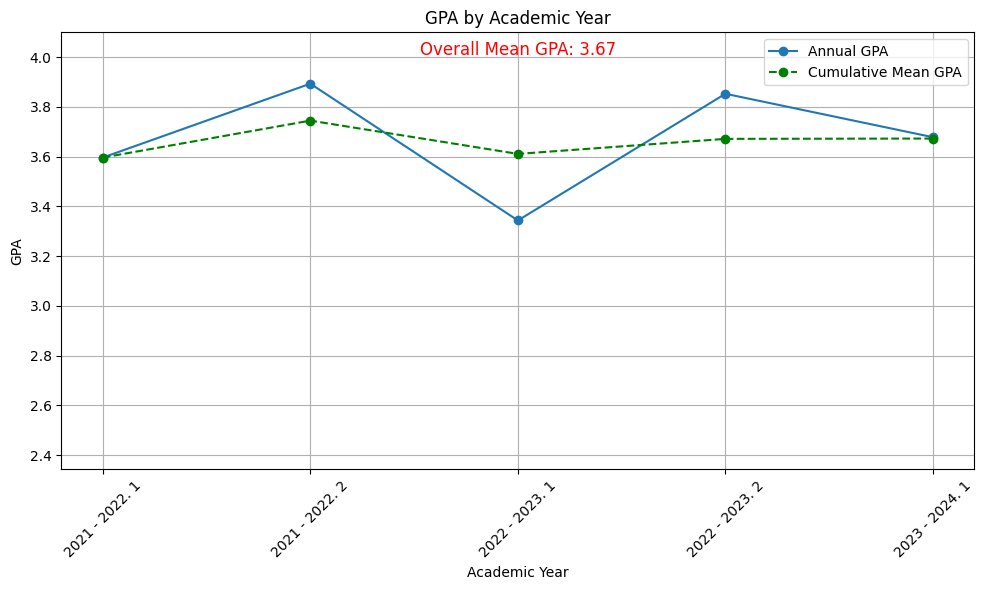

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from transcript import transcript_scrap, transcript_import
import time
import os

chat_id = "767413484"

def gpa_calculate(chat_id):
    df = transcript_scrap(
        chat_id
    )  # Make sure this function is defined and returns a DataFrame

    df_cleaned = df.dropna(subset=["Point"])
    df_cleaned["Weighted_Points"] = df_cleaned["Point"] * df_cleaned["Credit / ECTS"]

    gpa_data = df_cleaned.groupby("Academic Year").agg(
        {"Weighted_Points": "sum", "Credit / ECTS": "sum"}
    )

    gpa_data["GPA"] = gpa_data["Weighted_Points"] / gpa_data["Credit / ECTS"]
    gpa_data["Cumulative_Mean_GPA"] = gpa_data["GPA"].expanding().mean()

    plt.figure(figsize=(10, 6))
    plt.plot(
        gpa_data.index, gpa_data["GPA"], marker="o", linestyle="-", label="Annual GPA"
    )
    plt.plot(
        gpa_data.index,
        gpa_data["Cumulative_Mean_GPA"],
        marker="o",
        linestyle="--",
        color="g",
        label="Cumulative Mean GPA",
    )
    mean_gpa = gpa_data["GPA"].mean()
    plt.text(
        0.5,
        0.98,
        f"Overall Mean GPA: {mean_gpa:.2f}",
        transform=plt.gca().transAxes,
        horizontalalignment="center",
        color="red",
        fontsize=12,
        verticalalignment="top",
    )
    plt.xlabel("Academic Year")
    plt.ylabel("GPA")
    plt.title("GPA by Academic Year")
    plt.ylim(gpa_data["GPA"].min() - 1, 4.1)  # Adjusted to show min GPA to 4.1
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.tight_layout()
    plt.show()
    # filename = f"GPA_plot\\{chat_id}_GPA.png"
    # plt.savefig(filename)
    # directory = "GPA_plot"
    # if not os.path.exists(directory):
    #     os.makedirs(directory)

    # filename = os.path.join(directory, f"{chat_id}_GPA.png")
    # plt.savefig(filename)
    # plt.close()  # Close the plot to free up memory
    # time.sleep(1)
    # return filename

gpa_calculate(chat_id)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from transcript import transcript_scrap, transcript_import
import time
import os

chat_id = "767413484"


# def gpa_calculate(chat_id):
df = transcript_scrap(
    chat_id
)  # Make sure this function is defined and returns a DataFrame
ip_df = df[df["Traditional"] == "In progress"]
ip_df["Course title"].unique()

{'username': '210109032', 'password': 'Alisher_2004', 'modstring': '', 'LogIn': ' Log in '}


c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.htm

array(['Computer Vision', 'UX/UI design',
       'Equations of mathematical physics',
       'Theory of interest rates and random processes in life insurance',
       'Modeling and Simulation', 'Internship 2'], dtype=object)

In [ ]:
import telebot
import sqlite3
from telebot import types
import requests
from bs4 import BeautifulSoup
from transcript import transcript_scrap, transcript_import
from GPA_plot import gpa_plot
from fpdf import FPDF
import os


TOKEN = "6898801075:AAGFGEaPfukiQAOGGmh3cbyakKsgEoL3NQU"
bot = telebot.TeleBot(TOKEN)
user_data = {}

# Initialize the database and create a table if it doesn't exist
conn = sqlite3.connect("users.db", check_same_thread=False)
c = conn.cursor()
c.execute(
    """
CREATE TABLE IF NOT EXISTS users (
    chat_id INTEGER PRIMARY KEY,
    username TEXT,
    password TEXT,
    name_student TEXT,
    faculty TEXT,
    specialty TEXT,
    level TEXT,
    education_language TEXT,
    entry_date TEXT,
    graduation_date TEXT
)
"""
)
conn.commit()


@bot.message_handler(commands=["start"])
def send_welcome(message):
    chat_id = message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        main_page(chat_id)
    else:
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Log in", callback_data="login"))
        bot.send_message(
            chat_id,
            "Hi! 👋 I am your personal AI Advisor by SDU University for studying 📚🤖.\nClick on the 'Log in' button, and let's immerse ourselves in the world of your studies! 🚀",
            reply_markup=markup,
        )


@bot.callback_query_handler(func=lambda call: call.data == "transcript")
def callback_schedule(call):
    chat_id = call.message.chat.id
    print(chat_id)
    # bot.send_message(chat_id, "Обновление Транскрипта")

    # Создаем InlineKeyboardMarkup
    keyboard = types.InlineKeyboardMarkup(row_width=2)

    # Добавляем кнопки с названиями
    buttons = [
        types.InlineKeyboardButton("Year of study", callback_data="study_year"),
        types.InlineKeyboardButton("GPA Statistics", callback_data="gpa_statistics"),
        types.InlineKeyboardButton("GPA Calculate", callback_data="gpa_calculate"),
        types.InlineKeyboardButton("Grade", callback_data="grade"),
        types.InlineKeyboardButton("Credit / ECTS", callback_data="credit_ects"),
        types.InlineKeyboardButton("Point", callback_data="point"),
    ]

    keyboard.add(*buttons)

    # Отправляем сообщение с клавиатурой
    bot.send_message(chat_id, "Select an option to display:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: call.data == "study_year")
def callback_study_year(call):
    chat_id = call.message.chat.id
    print(chat_id)
    df = transcript_scrap(chat_id)
    unique_study_year = df["Study Year"].unique()
    keyboard = types.InlineKeyboardMarkup(row_width=1)
    for study_year in unique_study_year:
        button = types.InlineKeyboardButton(
            str(study_year), callback_data=f"study_year_{study_year}"
        )
        keyboard.add(button)
    # Add a button for all study years
    keyboard.add(
        types.InlineKeyboardButton("All Study Years", callback_data="study_year_all")
    )

    bot.send_message(chat_id, "Select a study year:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: call.data.startswith("study_year_"))
def handle_study_year_selection(call):
    chat_id = call.message.chat.id
    df = transcript_import(chat_id)
    # df.drop(columns=["chatID"], inplace=True)  # Delete the "chatID" column
    print(chat_id)
    print(df)
    study_year = call.data.split("_")[2]

    transcripts_folder = "Transcripts"
    if not os.path.exists(transcripts_folder):
        os.makedirs(transcripts_folder)

    if study_year == "all":
        # Send the original DataFrame without filtering
        file_path = os.path.join(transcripts_folder, f"{chat_id}_transcript_all.xlsx")
        df.to_excel(file_path, index=False)
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        with open(file_path, "rb") as file:
            bot.send_document(chat_id, file, reply_markup=keyboard)
    else:
        filtered_df = df[df["Study Year"] == int(study_year)]
        filtered_df = filtered_df.drop(columns=["chatID"])
        sorted_df = filtered_df.sort_values(by=["Study Program"])

        file_path = os.path.join(
            transcripts_folder, f"{chat_id}_transcript_{study_year}.xlsx"
        )
        sorted_df.to_excel(file_path, index=False)

        # Add a button for all study years
        keyboard_all = types.InlineKeyboardMarkup()
        keyboard_all.add(
            types.InlineKeyboardButton(
                "All Study Years", callback_data="study_year_all"
            )
        )

        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        with open(file_path, "rb") as file:
            bot.send_document(chat_id, file, reply_markup=keyboard)
            # bot.send_message(
            #     chat_id, "Please select a study year:", reply_markup=keyboard_all
            # )


# os.remove(file_path)


@bot.callback_query_handler(func=lambda call: call.data == "gpa_statistics")
def callback_study_year(call):
    chat_id = call.message.chat.id
    filename = gpa_plot(chat_id)
    try:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        with open(filename, "rb") as file:
            bot.send_photo(
                chat_id, file, reply_markup=keyboard
            )  # Changed from send_document to send_photo
    finally:
        if os.path.exists(filename):
            print(f"File {filename} has been deleted.")


user_gpa_calculate = {}


def get_user_gpa_data(chat_id):
    if chat_id not in user_gpa_calculate:
        user_gpa_calculate[chat_id] = {
            "ip_df_keys": [],
            "current_index": 0,
            "ip_scores": {},
        }
    return user_gpa_calculate[chat_id]


@bot.callback_query_handler(func=lambda call: call.data == "gpa_calculate")
def callback_gpa_calculate(call):
    chat_id = call.message.chat.id
    df = transcript_scrap(
        chat_id
    )  # Ensure this function is defined to return a DataFrame
    ip_df = df[df["Traditional"] == "In progress"]
    ip_df_keys = ip_df["Course title"].unique()

    user_info = get_user_gpa_data(chat_id)
    user_info["ip_df_keys"] = ip_df_keys
    user_info["current_index"] = 0
    user_info["ip_scores"] = {}

    send_score_request(call)


def send_score_request(call):
    chat_id = call.message.chat.id
    user_info = get_user_gpa_data(chat_id)
    ip_df_keys = user_info["ip_df_keys"]
    current_index = user_info["current_index"]

    keyboard = types.InlineKeyboardMarkup(row_width=2)
    score_ranges = [
        (0, 49),
        (50, 54),
        (55, 59),
        (60, 64),
        (65, 69),
        (70, 74),
        (75, 79),
        (80, 84),
        (85, 89),
        (90, 94),
        (95, 100),
    ]

    # Create buttons for each score range
    for score_range in score_ranges:
        button_text = f"{score_range[0]}-{score_range[1]}"
        button_data = f"gpa_{score_range[0]}_{score_range[1]}"
        button = types.InlineKeyboardButton(button_text, callback_data=button_data)
        keyboard.add(button)

    if current_index < len(ip_df_keys):
        course_key = ip_df_keys[current_index]
        bot.send_message(
            chat_id,
            text=f"Your score in: {course_key}\nPlease select your score range for this course:",
            reply_markup=keyboard,
        )


@bot.callback_query_handler(func=lambda call: call.data.startswith("gpa_"))
def handle_score_range_selection(call):
    chat_id = call.message.chat.id
    user_info = get_user_gpa_data(chat_id)
    ip_df_keys = user_info["ip_df_keys"]
    current_index = user_info["current_index"]
    score_range = call.data

    # Store the score
    ip_scores = user_info["ip_scores"]
    course_key = ip_df_keys[current_index]
    ip_scores[course_key] = score_range

    # Move to the next course
    if current_index + 1 < len(ip_df_keys):
        user_info["current_index"] += 1
        bot.answer_callback_query(call.id, "Score recorded")
        send_score_request(call)
    else:
        bot.answer_callback_query(call.id, "All scores recorded. Processing results.")
        # Process results here, like calculating GPA, etc.
        # Process results here, like calculating GPA, etc.

    # Once all scores are collected, you can continue processing
    # For example, you can calculate GPA based on the collected scores


# @bot.callback_query_handler(func=lambda call: call.data == "1_term")
# def callback_study_year(call):
#     chat_id = call.message.chat.id
#     df = transcript_scrap(chat_id, 1)
#     df =
#     # bot.send_message(chat_id, "Выберите семестр:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: True)
def handle_callback_query(call):
    user_id = call.from_user.id

    if call.data == "login":
        handle_login_callback(call)
    elif call.data in ["confirm", "cancel"]:
        if user_data.get(user_id):
            if call.data == "confirm":
                confirm_registration(call, user_id)
            elif call.data == "cancel":
                cancel_registration(call, user_id)
        else:
            bot.answer_callback_query(call.id, "Session expired, please start again.")
    elif call.data == "profile":
        handle_profile_callback(call)
    elif call.data == "main_page":
        handle_main_page_callback(call)


def handle_login_callback(call):
    bot.reply_to(call.message, "Enter your Student number from oldmy.sdu.edu.kz")
    bot.register_next_step_handler(call.message, process_username_step)


def process_username_step(message):
    user_id = message.from_user.id
    user_data[user_id] = {"chat_id": user_id, "username": message.text}
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE username = ?", (message.text,))
    existing_user = c.fetchone()

    if existing_user:
        bot.send_message(user_id, "A user with that name already exists!")
        send_welcome(message)
    else:
        bot.reply_to(message, "Enter your portal password")
        bot.register_next_step_handler(message, process_password_step)


def process_password_step(message):
    user_id = message.from_user.id
    user_data[user_id]["password"] = message.text
    url = "https://oldmy.sdu.edu.kz/index.php"
    data = {
        "username": user_data[user_id]["username"],
        "password": message.text,
        "modstring": "",
        "LogIn": " Log in ",
    }

    response = requests.post(url, data=data, verify=False)
    soup = BeautifulSoup(response.text, "html.parser")
    if "incorrect" in soup.text.lower():
        bot.send_message(user_id, "The password is incorrect. Please try again!")
        send_welcome(message)
    else:
        # td_elements = soup.find_all("td", class_="clsTdInfo", style="color:#333")
        # user_data[user_id]["name_student"] = td_elements[1].text.strip()
        # user_data[user_id]["name_advisor"] = td_elements[3].text.strip()
        # user_data[user_id]["majority_student"] = td_elements[5].text.strip()

        login_url = "https://oldmy.sdu.edu.kz/index.php"

        # Perform login request to get cookies
        session = requests.Session()
        login_response = session.post(login_url, data=data, verify=False)

        # Check if login was successful
        if login_response.status_code == 200:
            print("Login successful.")
        else:
            print("Login failed.")
            exit()

        # URL for fetching transcript data
        transcript_url = "https://oldmy.sdu.edu.kz/index.php?mod=transkript"

        # Fetch transcript data using the established session (with cookies)
        transcript_response = session.get(transcript_url)

        # Parse the response HTML using BeautifulSoup
        soup = BeautifulSoup(transcript_response.text, "html.parser")

        user_data[user_id]["username"] = (
            soup.find("td", text="Student №:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["name_student"] = (
            soup.find("td", text="Student Name:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["faculty"] = (
            soup.find("td", text="Faculty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["specialty"] = (
            soup.find("td", text="Specialty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["level"] = (
            soup.find("td", text="Level:").find_next_sibling("td").get_text(strip=True)
        )
        user_data[user_id]["education_language"] = (
            soup.find("td", text="Education Language:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["entry_date"] = (
            soup.find("td", text="Entry Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["graduation_date"] = (
            soup.find("td", text="Graduation Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        keyboard = types.InlineKeyboardMarkup()
        keyboard.row(
            types.InlineKeyboardButton("✅", callback_data="confirm"),
            types.InlineKeyboardButton("❌", callback_data="cancel"),
        )
        bot.send_message(
            message.chat.id,
            f"Confirm your details:\nStudent name: {user_data[user_id]['name_student']}",
            reply_markup=keyboard,
        )


def confirm_registration(call, user_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute(
        "INSERT INTO users (chat_id, username, password, name_student, faculty, specialty, level, education_language, entry_date, graduation_date) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
        (
            user_data[user_id]["chat_id"],
            user_data[user_id]["username"],
            user_data[user_id]["password"],
            user_data[user_id]["name_student"],
            # user_data[user_id]["majority_student"],
            user_data[user_id]["faculty"],
            user_data[user_id]["specialty"],
            user_data[user_id]["level"],
            user_data[user_id]["education_language"],
            user_data[user_id]["entry_date"],
            user_data[user_id]["graduation_date"],
        ),
    )

    conn.commit()
    bot.send_message(user_id, "The data has been saved successfully!")
    main_page(call.message.chat.id)


def cancel_registration(call, user_id):
    bot.send_message(user_id, "Please repeat the data entry.")
    send_welcome(call.message)


def get_student_data_by_chat_id(chat_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE chat_id = ?", (chat_id,))
    student_data = c.fetchone()
    return student_data


def handle_profile_callback(call):
    chat_id = call.message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        message_text = (
            f"<b>Student number:</b> {student_data[1]} 😊\n"
            f"<b>Student name:</b> {student_data[3]} 😇\n"
            f"<b>Faculty:</b> {student_data[4]} 🏫\n"
            f"<b>Specialty:</b> {student_data[5]} 📘\n"
            f"<b>Level:</b> {student_data[6]} 🎓\n"
            f"<b>Education Language:</b> {student_data[7]} 🗣️\n"
            f"<b>Entry Date:</b> {student_data[8]} 📅\n"
            f"<b>Graduation Date:</b> {student_data[9]}🎉"
        )

        bot.send_message(
            chat_id, message_text, parse_mode="HTML", reply_markup=keyboard
        )

    else:
        bot.send_message(chat_id, "You don't have any saved profile data.")


def handle_main_page_callback(call):
    main_page(call.message.chat.id)


def main_page(chat_id):
    student_data = get_student_data_by_chat_id(chat_id)
    keyboard = types.InlineKeyboardMarkup()
    keyboard.add(types.InlineKeyboardButton("Profile👤", callback_data="profile"))
    keyboard.add(types.InlineKeyboardButton("Schedule🗓", callback_data="schedule"))
    keyboard.add(types.InlineKeyboardButton("Transcript🗂", callback_data="transcript"))
    bot.send_message(
        chat_id,
        f"Welcome, {student_data[3]}🙌🏻! How can I help you?😇",
        reply_markup=keyboard,
    )


bot.polling()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transcript import transcript_scrap, transcript_import
import time
import os


def gpa_plot(chat_id):
    df = transcript_scrap(
        chat_id
    )  # Make sure this function is defined and returns a DataFrame

    df_cleaned = df.dropna(subset=["Point"])
    df_cleaned["Weighted_Points"] = df_cleaned["Point"] * df_cleaned["Credit / ECTS"]

    gpa_data = df_cleaned.groupby("Academic Year").agg(
        {"Weighted_Points": "sum", "Credit / ECTS": "sum"}
    )

    gpa_data["GPA"] = gpa_data["Weighted_Points"] / gpa_data["Credit / ECTS"]
    gpa_data["Cumulative_Mean_GPA"] = gpa_data["GPA"].expanding().mean()

    plt.figure(figsize=(10, 6))
    plt.plot(gpa_data.index, gpa_data["GPA"], marker="o", linestyle="-", label="SPA")
    plt.plot(
        gpa_data.index,
        gpa_data["Cumulative_Mean_GPA"],
        marker="o",
        linestyle="--",
        color="g",
        label="Cumulative Mean GPA",
    )
    mean_gpa = gpa_data["GPA"].mean()
    plt.text(
        0.5,
        0.98,
        f"Overall Mean GPA: {mean_gpa:.2f}",
        transform=plt.gca().transAxes,
        horizontalalignment="center",
        color="red",
        fontsize=12,
        verticalalignment="top",
    )
    plt.xlabel("Academic Year")
    plt.ylabel("GPA")
    plt.title("GPA by Academic Year")
    plt.ylim(gpa_data["GPA"].min() - 1, 4.1)  # Adjusted to show min GPA to 4.1
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.tight_layout()
    # plt.show()
    # filename = f"GPA_plot\\{chat_id}_GPA.png"
    # plt.savefig(filename)
    directory = "GPA_plot"
    if not os.path.exists(directory):
        os.makedirs(directory)

    filename = os.path.join(directory, f"{chat_id}_GPA.png")
    plt.savefig(filename)
    plt.close()  # Close the plot to free up memory
    time.sleep(1)
    return filename

In [58]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import sqlite3


chat_id = "767413484"

def get_username_password(chat_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT username, password FROM users WHERE chat_id = ?", (chat_id,))
    result = c.fetchone()
    conn.close()
    return result


def transcript_scrap(chat_id):
    username, password = get_username_password(chat_id)
    login_data = {
        "username": username,
        "password": password,
        "modstring": "",
        "LogIn": " Log in ",
    }
    print(login_data)
    login_url = "https://oldmy.sdu.edu.kz/index.php"
    transcript_url = "https://oldmy.sdu.edu.kz/index.php?mod=transkript"
    with requests.Session() as session:
        login_response = session.post(login_url, data=login_data, verify=False)
        transcript_response = session.get(transcript_url)
    soup = BeautifulSoup(transcript_response.text, "html.parser")
    rows = soup.find_all('tr', style="color:Maroon; font-size:10px; font-weight:bold")

    # Extract data from each row
    data = []

    for row in rows[:-1]:
        cols = row.find_all('td')
        # Extract text from each cell, handle empty cells and strip spaces
        cols = [ele.text.strip() if ele.text.strip() != '' else None for ele in cols]
        data.append(cols[2:])

    # Create a DataFrame
    df_sopu = pd.DataFrame(
        data, columns=["Internal_Credit", "Credit_ECTS", "SA", "GA", "SPA", "GPA"]
    )

    df_sopu["SA"] = df_sopu["SA"].str.replace("SA : ", "")
    df_sopu["GA"] = df_sopu["GA"].str.replace("GA : ", "")
    df_sopu["SPA"] = df_sopu["SPA"].str.replace("SPA : ", "")
    df_sopu["GPA"] = df_sopu["GPA"].str.replace("GPA : ", "")
    df_sopu[["Internal_Credit", "Credit_ECTS", "SA", "GA", "SPA", "GPA"]] = df_sopu[
        ["Internal_Credit", "Credit_ECTS", "SA", "GA", "SPA", "GPA"]
    ].apply(pd.to_numeric, errors="coerce")

    print(df_sopu)
    return df_sopu

df_soup = transcript_scrap(chat_id)

{'username': '210109032', 'password': 'Alisher_2004', 'modstring': '', 'LogIn': ' Log in '}


c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.htm

   Internal_Credit  Credit_ECTS     SA     GA   SPA   GPA
0               20           31  90.68  90.68  3.60  3.60
1               19           31  94.23  92.54  3.89  3.75
2               20           32  86.22  90.32  3.34  3.61
3               20           34  94.44  91.44  3.85  3.68
4               17           28  92.18  91.58  3.68  3.68
5               17           26   0.00  91.58  0.00  3.68


In [59]:
df_soup["Credit_ECTS"][:-1].sum()

156

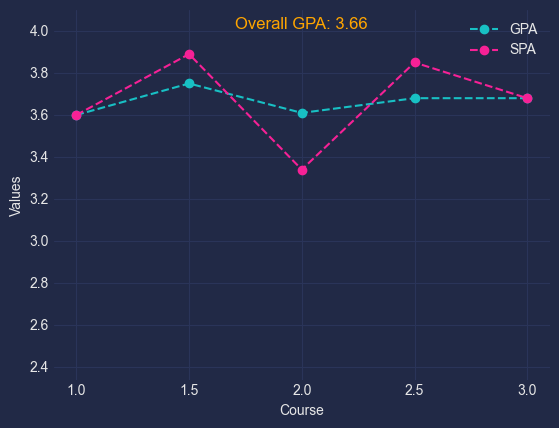

In [78]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import jv

# Importing the style and setting it
    plt.style.use(
        "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
    )

    if df_soup["SA"].iloc[-1] == 0:
        df_soup = df_soup.iloc[:-1]

    x = 1 + 0.5 * df_soup.index

    plt.plot(x, df_soup["GPA"], marker="o", linestyle="--", color="C0", label="GPA")
    plt.plot(x, df_soup["SPA"], marker="o", linestyle="--", color="C1", label="SPA")
    plt.xlabel("Course")
    plt.ylabel("Values")
    plt.ylim(df_soup[["GPA", "SPA"]].min().min() - 1, 4.1)
    plt.xticks(x)
    plt.legend()

    # Add text annotation for overall mean GPA
    mean_gpa = df_soup["GPA"].mean()
    plt.text(
        0.5,
        0.98,
        f"Overall GPA: {mean_gpa:.2f}",
        transform=plt.gca().transAxes,
        horizontalalignment="center",
        fontsize=12,
        verticalalignment="top",
        color="orange",  # Change color to orange
    )

    plt.show()
    directory = "GPA_plot"
    if not os.path.exists(directory):
        os.makedirs(directory)

    filename = os.path.join(directory, f"{chat_id}_GPA.png")
    plt.savefig(filename)
    plt.close()  # Close the plot to free up memory
    time.sleep(1)
    return filename

In [72]:
import plotly.graph_objects as go
import numpy as np

if df_soup["SA"].iloc[-1] == 0:
    df_soup = df_soup.iloc[:-1]

x = 1 + 0.5 * df_soup.index

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=x,
        y=df_soup["GPA"],
        mode="lines+markers",
        name="GPA",
        marker=dict(color="red"),
    )
)
fig.add_trace(
    go.Scatter(
        x=x,
        y=df_soup["SPA"],
        mode="lines+markers",
        name="SPA",
        marker=dict(color="blue"),
    )
)

fig.update_layout(
    xaxis=dict(title="Course"),
    yaxis=dict(title="Values", range=[df_soup[["GPA", "SPA"]].min().min() - 1, 4.1]),
    legend=dict(x=0, y=1, traceorder="normal"),
)

# Add text annotation for overall mean GPA
mean_gpa = df_soup["GPA"].mean()
fig.add_annotation(
    x=0.5,
    y=0.98,
    text=f"Overall Mean GPA: {mean_gpa:.2f}",
    showarrow=False,
    font=dict(color="red", size=12),
    xanchor="center",
    yanchor="top",
)

fig.show()

In [ ]:

    conn = sqlite3.connect("transcripts_gpa.db")
    c = conn.cursor()

    # Create the transcripts table if it doesn't exist
    c.execute(
        f"""CREATE TABLE IF NOT EXISTS u{chat_id} (
                    Academic_Year TEXT,
                    Course_Code TEXT,
                    Course_Title TEXT,
                    Internal_Credit INTEGER,
                    Credit_ECTS INTEGER,
                    Grade REAL,
                    Letter_Grade TEXT,
                    Point REAL,
                    Traditional TEXT,
                    Study_Program INTEGER,
                    Study_Year INTEGER,
                    chatID INTEGER
                )"""
    )

    # Commit changes to the database
    conn.commit()

    # Insert transcript data into the transcripts table
    # Add chatID column to the DataFrame
    df.to_sql(f"u{chat_id}", conn, if_exists="replace", index=False)

    # Close the connection
    conn.close()
    return df


def transcript_import(chat_id):
    # Connect to the SQLite database
    conn = sqlite3.connect("transcripts.db")

    # Construct the SQL query to select all columns from the user's transcript table
    sql_query = f"SELECT * FROM u{chat_id}"

    # Use pandas to read the SQL query result directly into a DataFrame
    df = pd.read_sql_query(sql_query, conn)

    # Close the connection
    conn.close()

    return df

In [82]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import sqlite3


# chat_id = "767413484"


def get_username_password(chat_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT username, password FROM users WHERE chat_id = ?", (chat_id,))
    result = c.fetchone()
    conn.close()
    return result


def transcript_scrap(chat_id):
    username, password = get_username_password(chat_id)
    login_data = {
        "username": username,
        "password": password,
        "modstring": "",
        "LogIn": " Log in ",
    }
    print(login_data)
    login_url = "https://oldmy.sdu.edu.kz/index.php"
    transcript_url = "https://oldmy.sdu.edu.kz/index.php?mod=transkript"
    with requests.Session() as session:
        login_response = session.post(login_url, data=login_data, verify=False)
        transcript_response = session.get(transcript_url)
    soup = BeautifulSoup(transcript_response.text, "html.parser")
    rows = soup.find_all("tr", style="color:Maroon; font-size:10px; font-weight:bold")

    # Extract data from each row
    data = []

    for row in rows[:-1]:
        cols = row.find_all("td")
        # Extract text from each cell, handle empty cells and strip spaces
        cols = [ele.text.strip() if ele.text.strip() != "" else None for ele in cols]
        data.append(cols[2:])

    # Create a DataFrame
    df_sopu = pd.DataFrame(
        data, columns=["Internal_Credit", "Credit_ECTS", "SA", "GA", "SPA", "GPA"]
    )

    df_sopu["SA"] = df_sopu["SA"].str.replace("SA : ", "")
    df_sopu["GA"] = df_sopu["GA"].str.replace("GA : ", "")
    df_sopu["SPA"] = df_sopu["SPA"].str.replace("SPA : ", "")
    df_sopu["GPA"] = df_sopu["GPA"].str.replace("GPA : ", "")
    df_sopu[["Internal_Credit", "Credit_ECTS", "SA", "GA", "SPA", "GPA"]] = df_sopu[
        ["Internal_Credit", "Credit_ECTS", "SA", "GA", "SPA", "GPA"]
    ].apply(pd.to_numeric, errors="coerce")
    df_sopu["chatID"] = chat_id

    print(df_sopu)

    conn = sqlite3.connect("transcripts_gpa.db")
    c = conn.cursor()

    # Create a table with a name dynamically generated from the chat_id
    c.execute(
        f"""CREATE TABLE IF NOT EXISTS u{chat_id} (
                    Internal_Credit INTEGER,
                    Credit_ECTS INTEGER,
                    SA REAL,
                    GA REAL,
                    SPA REAL,
                    GPA REAL,
                    chatID
                )"""
    )
    df_sopu.to_sql(f"u{chat_id}", conn, if_exists="replace", index=False)
    conn.close()

transcript_scrap(chat_id)

{'username': '210109032', 'password': 'Alisher_2004', 'modstring': '', 'LogIn': ' Log in '}


c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings

c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings

c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings



   Internal_Credit  Credit_ECTS     SA     GA   SPA   GPA     chatID
0               20           31  90.68  90.68  3.60  3.60  767413484
1               19           31  94.23  92.54  3.89  3.75  767413484
2               20           32  86.22  90.32  3.34  3.61  767413484
3               20           34  94.44  91.44  3.85  3.68  767413484
4               17           28  92.18  91.58  3.68  3.68  767413484
5               17           26   0.00  91.58  0.00  3.68  767413484


In [90]:
import telebot
import sqlite3
from telebot import types
import requests
from bs4 import BeautifulSoup
from transcript import transcript_scrap, transcript_import
from transcript_gpa import transcript_gpa_scrap, transcript_gpa_import
from GPA_plot import gpa_plot
from fpdf import FPDF
import os
from gpa_plot import gpa_plot_2


TOKEN = "6898801075:AAGFGEaPfukiQAOGGmh3cbyakKsgEoL3NQU"
bot = telebot.TeleBot(TOKEN)
user_data = {}

# Initialize the database and create a table if it doesn't exist
conn = sqlite3.connect("users.db", check_same_thread=False)
c = conn.cursor()
c.execute(
    """
CREATE TABLE IF NOT EXISTS users (
    chat_id INTEGER PRIMARY KEY,
    username TEXT,
    password TEXT,
    name_student TEXT,
    faculty TEXT,
    specialty TEXT,
    level TEXT,
    education_language TEXT,
    entry_date TEXT,
    graduation_date TEXT
)
"""
)
conn.commit()


@bot.message_handler(commands=["start"])
def send_welcome(message):
    chat_id = message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        main_page(chat_id)
    else:
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Log in", callback_data="login"))
        bot.send_message(
            chat_id,
            "Hi! 👋 I am your personal AI Advisor by SDU University for studying 📚🤖.\nClick on the 'Log in' button, and let's immerse ourselves in the world of your studies! 🚀",
            reply_markup=markup,
        )


@bot.callback_query_handler(func=lambda call: call.data == "update")
def callback_transcript(call):
    transcript_gpa_scrap(call.message.chat.id)
    transcript_scrap(call.message.chat.id)


@bot.callback_query_handler(func=lambda call: call.data == "transcript")
def callback_transcript(call):
    chat_id = call.message.chat.id
    # transcript_gpa_scrap(chat_id)
    # transcript_scrap(chat_id)

    print(chat_id)
    # bot.send_message(chat_id, "Обновление Транскрипта")

    # Создаем InlineKeyboardMarkup
    keyboard = types.InlineKeyboardMarkup(row_width=2)

    # Добавляем кнопки с названиями
    buttons = [
        types.InlineKeyboardButton("Year of study", callback_data="study_year"),
        types.InlineKeyboardButton("GPA Statistics", callback_data="gpa_statistics"),
        types.InlineKeyboardButton("GPA Calculate", callback_data="gpa_calculate"),
        types.InlineKeyboardButton("Grade", callback_data="grade"),
        types.InlineKeyboardButton("Credit / ECTS", callback_data="credit_ects"),
        types.InlineKeyboardButton("Point", callback_data="point"),
    ]

    keyboard.add(*buttons)

    # Отправляем сообщение с клавиатурой
    bot.send_message(chat_id, "Select an option to display:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: call.data == "study_year")
def callback_study_year(call):
    chat_id = call.message.chat.id
    print(chat_id)
    df = transcript_import(chat_id)
    unique_study_year = df["Study Year"].unique()
    keyboard = types.InlineKeyboardMarkup(row_width=1)
    for study_year in unique_study_year:
        button = types.InlineKeyboardButton(
            str(study_year), callback_data=f"study_year_{study_year}"
        )
        keyboard.add(button)
    # Add a button for all study years
    keyboard.add(
        types.InlineKeyboardButton("All Study Years", callback_data="study_year_all")
    )

    bot.send_message(chat_id, "Select a study year:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: call.data.startswith("study_year_"))
def handle_study_year_selection(call):
    chat_id = call.message.chat.id
    df = transcript_import(chat_id)
    # df.drop(columns=["chatID"], inplace=True)  # Delete the "chatID" column
    print(chat_id)
    print(df)
    study_year = call.data.split("_")[2]

    transcripts_folder = "Transcripts"
    if not os.path.exists(transcripts_folder):
        os.makedirs(transcripts_folder)

    if study_year == "all":
        # Send the original DataFrame without filtering
        df = df.drop(columns=["chatID"])
        file_path = os.path.join(transcripts_folder, f"{chat_id}_transcript_all.xlsx")
        df.to_excel(file_path, index=False)
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        with open(file_path, "rb") as file:
            bot.send_document(chat_id, file, reply_markup=keyboard)
    else:
        filtered_df = df[df["Study Year"] == int(study_year)]
        filtered_df = filtered_df.drop(columns=["chatID"])
        sorted_df = filtered_df.sort_values(by=["Study Program"])

        file_path = os.path.join(
            transcripts_folder, f"{chat_id}_transcript_{study_year}.xlsx"
        )
        sorted_df.to_excel(file_path, index=False)

        # Add a button for all study years
        keyboard_all = types.InlineKeyboardMarkup()
        keyboard_all.add(
            types.InlineKeyboardButton(
                "All Study Years", callback_data="study_year_all"
            )
        )

        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        with open(file_path, "rb") as file:
            bot.send_document(chat_id, file, reply_markup=keyboard)
            # bot.send_message(
            #     chat_id, "Please select a study year:", reply_markup=keyboard_all
            # )


# os.remove(file_path)


@bot.callback_query_handler(func=lambda call: call.data == "gpa_statistics")
def callback_study_year(call):
    chat_id = call.message.chat.id
    filename = gpa_plot_2(chat_id)
    try:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        with open(filename, "rb") as file:
            bot.send_photo(
                chat_id, file, reply_markup=keyboard
            )  # Changed from send_document to send_photo
    finally:
        if os.path.exists(filename):
            print(f"File {filename} has been deleted.")


user_gpa_calculate = {}


def get_user_gpa_data(chat_id):
    if chat_id not in user_gpa_calculate:
        user_gpa_calculate[chat_id] = {
            "ip_df_keys": [],
            "current_index": 0,
            "ip_scores": {},
        }
    return user_gpa_calculate[chat_id]


@bot.callback_query_handler(func=lambda call: call.data == "gpa_calculate")
def callback_gpa_calculate(call):
    chat_id = call.message.chat.id
    df = transcript_import(
        chat_id
    )  # Ensure this function is defined to return a DataFrame
    ip_df = df[df["Traditional"] == "In progress"]
    ip_df_keys = ip_df["Course title"].unique()

    user_info = get_user_gpa_data(chat_id)
    user_info["ip_df_keys"] = ip_df_keys
    user_info["current_index"] = 0
    user_info["ip_scores"] = {}

    send_score_request(call)


def send_score_request(call):
    chat_id = call.message.chat.id
    user_info = get_user_gpa_data(chat_id)
    ip_df_keys = user_info["ip_df_keys"]
    current_index = user_info["current_index"]

    keyboard = types.InlineKeyboardMarkup(row_width=2)
    score_ranges = [
        (0, 49),
        (50, 54),
        (55, 59),
        (60, 64),
        (65, 69),
        (70, 74),
        (75, 79),
        (80, 84),
        (85, 89),
        (90, 94),
        (95, 100),
    ]

    # Create buttons for each score range
    for score_range in score_ranges:
        button_text = f"{score_range[0]}-{score_range[1]}"
        button_data = f"gpa_{score_range[0]}_{score_range[1]}"
        button = types.InlineKeyboardButton(button_text, callback_data=button_data)
        keyboard.add(button)

    if current_index < len(ip_df_keys):
        course_key = ip_df_keys[current_index]
        bot.send_message(
            chat_id,
            text=f"Your score in: {course_key}\nPlease select your score range for this course:",
            reply_markup=keyboard,
        )


@bot.callback_query_handler(func=lambda call: call.data.startswith("gpa_"))
def handle_score_range_selection(call):
    chat_id = call.message.chat.id
    user_info = get_user_gpa_data(chat_id)
    ip_df_keys = user_info["ip_df_keys"]
    current_index = user_info["current_index"]
    score_range = call.data

    # Store the score
    ip_scores = user_info["ip_scores"]
    course_key = ip_df_keys[current_index]
    ip_scores[course_key] = score_range

    # Move to the next course
    if current_index + 1 < len(ip_df_keys):
        user_info["current_index"] += 1
        bot.answer_callback_query(call.id, "Score recorded")
        send_score_request(call)
    else:
        bot.answer_callback_query(call.id, "All scores recorded. Processing results.")
        # Process results here, like calculating GPA, etc.
        # Process results here, like calculating GPA, etc.

    # Once all scores are collected, you can continue processing
    # For example, you can calculate GPA based on the collected scores


# @bot.callback_query_handler(func=lambda call: call.data == "1_term")
# def callback_study_year(call):
#     chat_id = call.message.chat.id
#     df = transcript_scrap(chat_id, 1)
#     df =
#     # bot.send_message(chat_id, "Выберите семестр:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: True)
def handle_callback_query(call):
    user_id = call.from_user.id

    if call.data == "login":
        handle_login_callback(call)
    elif call.data in ["confirm", "cancel"]:
        if user_data.get(user_id):
            if call.data == "confirm":
                confirm_registration(call, user_id)
                transcript_gpa_scrap(call.message.chat.id)
                transcript_scrap(call.message.chat.id)
            elif call.data == "cancel":
                cancel_registration(call, user_id)
        else:
            bot.answer_callback_query(call.id, "Session expired, please start again.")
    elif call.data == "profile":
        handle_profile_callback(call)
    elif call.data == "main_page":
        handle_main_page_callback(call)


def handle_login_callback(call):
    bot.reply_to(call.message, "Enter your StudentID")
    bot.register_next_step_handler(call.message, process_username_step)


def process_username_step(message):
    user_id = message.from_user.id
    user_data[user_id] = {"chat_id": user_id, "username": message.text}
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE username = ?", (message.text,))
    existing_user = c.fetchone()

    if existing_user:
        bot.send_message(user_id, "A user with that name already exists!")
        send_welcome(message)
    else:
        bot.reply_to(message, "Enter your portal password")
        bot.register_next_step_handler(message, process_password_step)


def process_password_step(message):
    user_id = message.from_user.id
    user_data[user_id]["password"] = message.text
    url = "https://oldmy.sdu.edu.kz/index.php"
    data = {
        "username": user_data[user_id]["username"],
        "password": message.text,
        "modstring": "",
        "LogIn": " Log in ",
    }

    response = requests.post(url, data=data, verify=False)
    soup = BeautifulSoup(response.text, "html.parser")
    if "incorrect" in soup.text.lower():
        bot.send_message(user_id, "The password is incorrect. Please try again!")
        send_welcome(message)
    else:
        # td_elements = soup.find_all("td", class_="clsTdInfo", style="color:#333")
        # user_data[user_id]["name_student"] = td_elements[1].text.strip()
        # user_data[user_id]["name_advisor"] = td_elements[3].text.strip()
        # user_data[user_id]["majority_student"] = td_elements[5].text.strip()

        login_url = "https://oldmy.sdu.edu.kz/index.php"

        # Perform login request to get cookies
        session = requests.Session()
        login_response = session.post(login_url, data=data, verify=False)

        # Check if login was successful
        if login_response.status_code == 200:
            print("Login successful.")
        else:
            print("Login failed.")
            exit()

        # URL for fetching transcript data
        transcript_url = "https://oldmy.sdu.edu.kz/index.php?mod=transkript"

        # Fetch transcript data using the established session (with cookies)
        transcript_response = session.get(transcript_url)

        # Parse the response HTML using BeautifulSoup
        soup = BeautifulSoup(transcript_response.text, "html.parser")

        user_data[user_id]["username"] = (
            soup.find("td", text="Student №:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["name_student"] = (
            soup.find("td", text="Student Name:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["faculty"] = (
            soup.find("td", text="Faculty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["specialty"] = (
            soup.find("td", text="Specialty:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["level"] = (
            soup.find("td", text="Level:").find_next_sibling("td").get_text(strip=True)
        )
        user_data[user_id]["education_language"] = (
            soup.find("td", text="Education Language:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["entry_date"] = (
            soup.find("td", text="Entry Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        user_data[user_id]["graduation_date"] = (
            soup.find("td", text="Graduation Date:")
            .find_next_sibling("td")
            .get_text(strip=True)
        )
        keyboard = types.InlineKeyboardMarkup()
        keyboard.row(
            types.InlineKeyboardButton("✅", callback_data="confirm"),
            types.InlineKeyboardButton("❌", callback_data="cancel"),
        )
        bot.send_message(
            message.chat.id,
            f"Confirm your details:\nStudent name: {user_data[user_id]['name_student']}",
            reply_markup=keyboard,
        )


def confirm_registration(call, user_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute(
        "INSERT INTO users (chat_id, username, password, name_student, faculty, specialty, level, education_language, entry_date, graduation_date) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
        (
            user_data[user_id]["chat_id"],
            user_data[user_id]["username"],
            user_data[user_id]["password"],
            user_data[user_id]["name_student"],
            # user_data[user_id]["majority_student"],
            user_data[user_id]["faculty"],
            user_data[user_id]["specialty"],
            user_data[user_id]["level"],
            user_data[user_id]["education_language"],
            user_data[user_id]["entry_date"],
            user_data[user_id]["graduation_date"],
        ),
    )

    conn.commit()
    bot.send_message(user_id, "The data has been saved successfully!")
    main_page(call.message.chat.id)


def cancel_registration(call, user_id):
    bot.send_message(user_id, "Please repeat the data entry.")
    send_welcome(call.message)


def get_student_data_by_chat_id(chat_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE chat_id = ?", (chat_id,))
    student_data = c.fetchone()
    return student_data


def handle_profile_callback(call):
    chat_id = call.message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to main page", callback_data="main_page")
        )
        message_text = (
            f"<b>Student number:</b> {student_data[1]} 😊\n"
            f"<b>Student name:</b> {student_data[3]} 😇\n"
            f"<b>Faculty:</b> {student_data[4]} 🏫\n"
            f"<b>Specialty:</b> {student_data[5]} 📘\n"
            f"<b>Level:</b> {student_data[6]} 🎓\n"
            f"<b>Education Language:</b> {student_data[7]} 🗣️\n"
            f"<b>Entry Date:</b> {student_data[8]} 📅\n"
            f"<b>Graduation Date:</b> {student_data[9]}🎉"
        )

        bot.send_message(
            chat_id, message_text, parse_mode="HTML", reply_markup=keyboard
        )

    else:
        bot.send_message(chat_id, "You don't have any saved profile data.")


def handle_main_page_callback(call):
    main_page(call.message.chat.id)


def main_page(chat_id):
    student_data = get_student_data_by_chat_id(chat_id)
    keyboard = types.InlineKeyboardMarkup()
    keyboard.add(types.InlineKeyboardButton("Profile👤", callback_data="profile"))
    keyboard.add(types.InlineKeyboardButton("Transcript🗂", callback_data="transcript"))
    keyboard.add(
        types.InlineKeyboardButton("Update the data🔄", callback_data="update")
    )
    bot.send_message(
        chat_id,
        f"Welcome, {student_data[3]}🙌🏻! How can I help you?😇",
        reply_markup=keyboard,
    )


bot.polling()

In [1]:
import telebot
import sqlite3
from telebot import types
import requests
from bs4 import BeautifulSoup
from transcript import transcript_scrap, transcript_import
from transcript_gpa import transcript_gpa_scrap, transcript_gpa_import
from gpa_plot import gpa_plot
from fpdf import FPDF
import os
import numpy as np


TOKEN = "7108747833:AAFDwjRiofG-fpge1a4ToHbtuZGQIRG6z-g"
bot = telebot.TeleBot(TOKEN)
user_data = {}

# Initialize the database and create a table if it doesn't exist
conn = sqlite3.connect("users.db", check_same_thread=False)
c = conn.cursor()
c.execute(
    """
CREATE TABLE IF NOT EXISTS users (
    chat_id INTEGER PRIMARY KEY,
    username TEXT,
    password TEXT,
    name_student TEXT,
    faculty TEXT,
    specialty TEXT,
    level TEXT,
    education_language TEXT,
    entry_date TEXT,
    graduation_date TEXT
)
"""
)
conn.commit()


@bot.message_handler(commands=["start"])
def send_welcome(message):
    chat_id = message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        main_page(chat_id)
    else:
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Log in", callback_data="login"))
        bot.send_message(
            chat_id,
            "Hi! 👋 I am your personal AI Advisor by SDU University for studying 📚🤖.\nClick on the 'Log in' button, and let's immerse ourselves in the world of your studies! 🚀",
            reply_markup=markup,
        )


@bot.message_handler(commands=["menu"])
def send_menu(message):
    chat_id = message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data is None:
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Log in", callback_data="login"))
        bot.send_message(
            chat_id,
            "I'm sorry, you need to log in from the beginning 😔",
            reply_markup=markup,
        )
    else:
        main_page(chat_id)


@bot.message_handler(commands=["help"])
def send_help(message):
    chat_id = message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data is None:
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Log in", callback_data="login"))
        bot.send_message(
            chat_id,
            "I'm sorry, you need to log in from the beginning 😔",
            reply_markup=markup,
        )
    else:
        bot.send_message(
            chat_id,
            "Здесь может быть ваша реклама 🙂",
            # reply_markup=markup,
        )


@bot.callback_query_handler(func=lambda call: call.data == "update")
def update_all(call):
    transcript_gpa_scrap(call.message.chat.id)
    transcript_scrap(call.message.chat.id)


@bot.callback_query_handler(func=lambda call: call.data == "transcript")
def callback_transcript(call):
    chat_id = call.message.chat.id
    # transcript_gpa_scrap(chat_id)
    # transcript_scrap(chat_id)

    print(chat_id)
    # bot.send_message(chat_id, "Обновление Транскрипта")

    # Создаем InlineKeyboardMarkup
    keyboard = types.InlineKeyboardMarkup(row_width=2)

    # Добавляем кнопки с названиями
    buttons = [
        types.InlineKeyboardButton("Year of study", callback_data="study_year"),
        types.InlineKeyboardButton("GPA Statistics", callback_data="gpa_statistics"),
        types.InlineKeyboardButton("GPA Calculate", callback_data="gpa_calculate"),
        types.InlineKeyboardButton("Grade", callback_data="grade"),
        types.InlineKeyboardButton("Credit / ECTS", callback_data="credit_ects"),
        types.InlineKeyboardButton("Point", callback_data="point"),
    ]

    keyboard.add(*buttons)

    # Отправляем сообщение с клавиатурой
    bot.send_message(chat_id, "Select an option to display:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: call.data == "study_year")
def callback_study_year(call):
    chat_id = call.message.chat.id
    print(chat_id)
    df = transcript_import(chat_id)
    unique_study_year = df["Study Year"].unique()
    keyboard = types.InlineKeyboardMarkup(row_width=1)
    for study_year in unique_study_year:
        button = types.InlineKeyboardButton(
            str(study_year), callback_data=f"study_year_{study_year}"
        )
        keyboard.add(button)
    # Add a button for all study years
    keyboard.add(
        types.InlineKeyboardButton("All", callback_data="study_year_all"),
        types.InlineKeyboardButton("🔙", callback_data="study_year"),
    )

    bot.send_message(chat_id, "Select a study year:", reply_markup=keyboard)


def get_max_column_widths(pdf, df, padding=6):
    col_widths = []
    for col in df.columns:
        header_width = pdf.get_string_width(str(col))
        max_data_width = max([pdf.get_string_width(str(item)) for item in df[col]])
        max_width = max(header_width, max_data_width) + padding
        col_widths.append(max_width)
    return col_widths


@bot.callback_query_handler(func=lambda call: call.data.startswith("study_year_"))
def handle_study_year_selection(call):
    chat_id = call.message.chat.id
    # keyboard = types.InlineKeyboardMarkup()
    # keyboard.add(
    #     # types.InlineKeyboardButton("Go to menu", callback_data="main_page"),
    #     types.InlineKeyboardButton("🔙", callback_data="study_year")
    # )
    df = transcript_import(chat_id)

    # df.drop(columns=["chatID"], inplace=True)  # Delete the "chatID" column
    print(chat_id)

    df["Point"] = df["Point"].replace(np.nan, 0)
    print(df)
    study_year = call.data.split("_")[2]
    print(study_year)

    transcripts_folder = "Transcripts"
    if not os.path.exists(transcripts_folder):
        os.makedirs(transcripts_folder)

    if study_year == "all":
        # Send the original DataFrame without filtering

        # file_path = os.path.join(transcripts_folder, f"{chat_id}_transcript_all.xlsx")
        # df.to_excel(file_path, index=False)

        # Определяем ширину столбцов и высоту строк автоматически
        # col_widths = [pdf.get_string_width(str(col)) + 6 for col in df.columns]
        # pdf = FPDF(orientation="L")
        pdf = FPDF(orientation="L")
        pdf.add_page()
        pdf.add_font("DejaVu", "", "DejaVuSansCondensed.ttf", uni=True)
        pdf.set_font("DejaVu", "", 8)
        df = df.drop(columns=["chatID", "Study Program", "Study Year"])
        print(df)
        col_widths = get_max_column_widths(pdf, df)

        row_height = 10

        # Adding column headers
        for col_width, col in zip(col_widths, df.columns):
            pdf.cell(col_width, row_height, str(col), border=1)
        pdf.ln(row_height)

        # Adding data rows
        for row in df.values:
            for col_width, item in zip(col_widths, row):
                pdf.cell(col_width, row_height, str(item), border=1)
            pdf.ln(row_height)

        # Save PDF to file
        file_path_pdf = f"{transcripts_folder}/{chat_id}_transcript_all.pdf"
        pdf.output(file_path_pdf)

        # Send PDF to user via Telegram Bot
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to menu", callback_data="main_page")
        )

        # Open and send the PDF file as a document
        try:
            with open(file_path_pdf, "rb") as file:
                bot.send_document(chat_id, file, reply_markup=keyboard)
        except FileNotFoundError:
            print("Error: File not found.")
    else:
        # pdf = FPDF(orientation="L")
        pdf = FPDF(orientation="L")
        pdf.add_page()
        pdf.add_font("DejaVu", "", "DejaVuSansCondensed.ttf", uni=True)
        pdf.set_font("DejaVu", "", 8)
        filtered_df = df[df["Study Year"] == int(study_year)]
        # filtered_df = filtered_df.drop(columns=["chatID"])
        sorted_df = filtered_df.sort_values(by=["Study Program"])
        sorted_df = filtered_df.drop(columns=["chatID", "Study Program", "Study Year"])
        print(sorted_df)
        # file_path = os.path.join(
        #     transcripts_folder, f"{chat_id}_transcript_{study_year}.xlsx"
        # )
        # sorted_df.to_excel(file_path, index=False)

        # # Add a button for all study years
        # keyboard_all = types.InlineKeyboardMarkup()
        # keyboard_all.add(
        #     types.InlineKeyboardButton(
        #         "All Study Years", callback_data="study_year_all"
        #     )
        # )

        # keyboard = types.InlineKeyboardMarkup()
        # keyboard.add(
        #     types.InlineKeyboardButton("Go to menu", callback_data="main_page")
        # )
        # with open(file_path, "rb") as file:
        #     bot.send_document(chat_id, file, reply_markup=keyboard)
        #     # bot.send_message(
        #     #     chat_id, "Please select a study year:", reply_markup=keyboard_all
        #     # )

        col_widths = get_max_column_widths(pdf, sorted_df)

        row_height = 10

        # Adding column headers
        for col_width, col in zip(col_widths, sorted_df.columns):
            pdf.cell(col_width, row_height, str(col), border=1)
        pdf.ln(row_height)

        # Adding data rows
        for row in sorted_df.values:
            for col_width, item in zip(col_widths, row):
                pdf.cell(col_width, row_height, str(item), border=1)
            pdf.ln(row_height)

        # Save PDF to file
        file_path_pdf = f"{transcripts_folder}/{chat_id}_transcript_{study_year}.pdf"
        pdf.output(file_path_pdf)

        # Send PDF to user via Telegram Bot
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to menu", callback_data="main_page")
        )

        # Open and send the PDF file as a document
        try:
            with open(file_path_pdf, "rb") as file:
                bot.send_document(chat_id, file, reply_markup=keyboard)
        except FileNotFoundError:
            print("Error: File not found.")


# os.remove(file_path)


@bot.callback_query_handler(func=lambda call: call.data == "gpa_statistics")
def gpa_statistics(call):
    chat_id = call.message.chat.id
    filename = gpa_plot(chat_id)
    try:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to menu", callback_data="main_page")
        )
        with open(filename, "rb") as file:
            bot.send_photo(
                chat_id, file, reply_markup=keyboard
            )  # Changed from send_document to send_photo
    finally:
        if os.path.exists(filename):
            print(f"File {filename} has been deleted.")


user_gpa_calculate = {}


def get_user_gpa_data(chat_id):
    if chat_id not in user_gpa_calculate:
        user_gpa_calculate[chat_id] = {
            "ip_df_keys": [],
            "current_index": 0,
            "ip_scores": {},
        }
    return user_gpa_calculate[chat_id]


@bot.callback_query_handler(func=lambda call: call.data == "gpa_calculate")
def callback_gpa_calculate(call):
    chat_id = call.message.chat.id
    df = transcript_import(
        chat_id
    )  # Ensure this function is defined to return a DataFrame
    ip_df = df[df["Traditional"] == "In progress"]
    ip_df_keys = ip_df["Course title"].unique()

    user_info = get_user_gpa_data(chat_id)
    user_info["ip_df_keys"] = ip_df_keys
    user_info["current_index"] = 0
    user_info["ip_scores"] = {}

    send_score_request(call)


def send_score_request(call):
    chat_id = call.message.chat.id
    user_info = get_user_gpa_data(chat_id)
    ip_df_keys = user_info["ip_df_keys"]
    current_index = user_info["current_index"]

    keyboard = types.InlineKeyboardMarkup(
        row_width=2
    )  # Изменяем row_width на 2 для двух столбцов
    score_ranges = [
        ("SKIP", None),
        (0, 49),
        (50, 54),
        (55, 59),
        (60, 64),
        (65, 69),
        (70, 74),
        (75, 79),
        (80, 84),
        (85, 89),
        (90, 94),
        (95, 100),
    ]

    # Создаем список кнопок для каждого столбца
    column1 = []
    column2 = []

    for score_range in score_ranges:
        if score_range[0] == "SKIP":
            button_text = "SKIP"
            button_data = "skip_button"
        else:
            button_text = f"{score_range[0]}-{score_range[1]}"
            button_data = f"gpa_{score_range[0]}_{score_range[1]}"

        button = types.InlineKeyboardButton(button_text, callback_data=button_data)

        # Добавляем кнопку в соответствующий столбец
        if len(column1) <= len(column2):
            column1.append(button)
        else:
            column2.append(button)

    # Добавляем кнопки в два столбца
    for button1, button2 in zip(column1, column2):
        keyboard.add(button1, button2)

    if current_index < len(ip_df_keys):
        course_key = ip_df_keys[current_index]
        bot.send_message(
            chat_id,
            text=f"Please select your score range for course\n <b>{course_key}</b>",
            reply_markup=keyboard,
            parse_mode="HTML",  # Разрешаем HTML-разметку
        )


@bot.callback_query_handler(
    func=lambda call: call.data.startswith("gpa_") or call.data == "skip_button"
)
def handle_score_range_selection(call):
    chat_id = call.message.chat.id
    user_info = get_user_gpa_data(chat_id)
    ip_df_keys = user_info["ip_df_keys"]
    current_index = user_info["current_index"]
    score_range = call.data

    # Store the score
    if score_range != "skip_button":
        ip_scores = user_info["ip_scores"]
        course_key = ip_df_keys[current_index]
        ip_scores[course_key] = score_range

    # Move to the next course
    if current_index + 1 < len(ip_df_keys):
        if score_range == "skip_button":
            bot.answer_callback_query(call.id, "Course skipped")
        else:
            bot.answer_callback_query(call.id, "Score recorded")
        user_info["current_index"] += 1
        send_score_request(call)
    else:
        bot.answer_callback_query(call.id, "All scores recorded. Processing results.")
        # Print the stored scores
        ip_scores = user_info["ip_scores"]
        for course, score_range in ip_scores.items():
            print(f"Course: {course}, Score Range: {score_range}")

        # Process results here, like calculating GPA, etc.
        # Process results here, like calculating GPA, etc.

    # Once all scores are collected, you can continue processing
    # For example, you can calculate GPA based on the collected scores


# @bot.callback_query_handler(func=lambda call: call.data == "1_term")
# def callback_study_year(call):
#     chat_id = call.message.chat.id
#     df = transcript_scrap(chat_id, 1)
#     df =
#     # bot.send_message(chat_id, "Выберите семестр:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: True)
def handle_callback_query(call):
    user_id = call.from_user.id

    if call.data == "login":
        handle_login_callback(call)
    elif call.data in ["confirm", "cancel"]:
        if user_data.get(user_id):
            if call.data == "confirm":
                confirm_registration(call, user_id)
                transcript_gpa_scrap(call.message.chat.id)
                transcript_scrap(call.message.chat.id)
            elif call.data == "cancel":
                cancel_registration(call, user_id)
        else:
            bot.answer_callback_query(call.id, "Session expired, please start again.")
    elif call.data == "profile":
        handle_profile_callback(call)
    elif call.data == "main_page":
        handle_main_page_callback(call)


def handle_login_callback(call):
    bot.reply_to(call.message, "Enter your StudentID")
    bot.register_next_step_handler(call.message, process_username_step)


def process_username_step(message):
    user_id = message.from_user.id

    user_data[user_id] = {"chat_id": user_id, "username": message.text}
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE username = ?", (message.text,))
    existing_user = c.fetchone()

    if existing_user:
        bot.send_message(user_id, "A user with that name already exists!")
        send_welcome(message)
    else:
        bot.reply_to(message, "Enter your portal password")
        bot.register_next_step_handler(message, process_password_step)


def process_password_step(message):
    user_id = message.from_user.id
    user_data[user_id]["password"] = message.text
    url = "https://oldmy.sdu.edu.kz/index.php"
    data = {
        "username": user_data[user_id]["username"],
        "password": message.text,
        "modstring": "",
        "LogIn": " Log in ",
    }

    response = requests.post(url, data=data, verify=False)
    soup = BeautifulSoup(response.text, "html.parser")
    if "incorrect" in soup.text.lower():
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Log in", callback_data="login"))
        bot.send_message(
            user_id,
            "The login or password is incorrect. Please try again!🫣",
            reply_markup=markup,
        )
        # send_welcome(message)
    else:
        # td_elements = soup.find_all("td", class_="clsTdInfo", style="color:#333")
        # user_data[user_id]["name_student"] = td_elements[1].text.strip()
        # user_data[user_id]["name_advisor"] = td_elements[3].text.strip()
        # user_data[user_id]["majority_student"] = td_elements[5].text.strip()

        login_url = "https://oldmy.sdu.edu.kz/index.php"

        # Perform login request to get cookies
        session = requests.Session()
        login_response = session.post(login_url, data=data, verify=False)

        # Check if login was successful
        if login_response.status_code == 200:
            print("Login successful.")
        else:
            print("Login failed.")
            exit()

        # URL for fetching transcript data
        transcript_url = "https://oldmy.sdu.edu.kz/index.php?mod=transkript"

        # Fetch transcript data using the established session (with cookies)
        transcript_response = session.get(transcript_url)

        # Parse the response HTML using BeautifulSoup
        soup = BeautifulSoup(transcript_response.text, "html.parser")
        print(soup)

        td = soup.find("td", text="Student №:")
        if td is None:
            markup = types.InlineKeyboardMarkup()
            markup.add(types.InlineKeyboardButton(text="Log in", callback_data="login"))
            bot.send_message(
                user_id,
                "The login or password is incorrect. Please try again!🫣",
                reply_markup=markup,
            )
            # send_welcome(message)
        else:

            user_data[user_id]["username"] = (
                soup.find("td", text="Student №:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )

            user_data[user_id]["name_student"] = (
                soup.find("td", text="Student Name:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )
            user_data[user_id]["faculty"] = (
                soup.find("td", text="Faculty:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )
            user_data[user_id]["specialty"] = (
                soup.find("td", text="Specialty:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )
            user_data[user_id]["level"] = (
                soup.find("td", text="Level:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )
            user_data[user_id]["education_language"] = (
                soup.find("td", text="Education Language:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )
            user_data[user_id]["entry_date"] = (
                soup.find("td", text="Entry Date:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )
            user_data[user_id]["graduation_date"] = (
                soup.find("td", text="Graduation Date:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )
            keyboard = types.InlineKeyboardMarkup()
            keyboard.row(
                types.InlineKeyboardButton("✅", callback_data="confirm"),
                types.InlineKeyboardButton("❌", callback_data="cancel"),
            )
            bot.send_message(
                message.chat.id,
                f"Confirm your details:\nStudent name: {user_data[user_id]['name_student']}",
                reply_markup=keyboard,
            )


def confirm_registration(call, user_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute(
        "INSERT INTO users (chat_id, username, password, name_student, faculty, specialty, level, education_language, entry_date, graduation_date) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
        (
            user_data[user_id]["chat_id"],
            user_data[user_id]["username"],
            user_data[user_id]["password"],
            user_data[user_id]["name_student"],
            user_data[user_id]["faculty"],
            user_data[user_id]["specialty"],
            user_data[user_id]["level"],
            user_data[user_id]["education_language"],
            user_data[user_id]["entry_date"],
            user_data[user_id]["graduation_date"],
        ),
    )

    conn.commit()
    bot.send_message(user_id, "The data has been saved successfully!")
    main_page(call.message.chat.id)


def cancel_registration(call, user_id):
    bot.send_message(user_id, "Please repeat the data entry.")
    send_welcome(call.message)


def get_student_data_by_chat_id(chat_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE chat_id = ?", (chat_id,))
    student_data = c.fetchone()
    return student_data


def handle_profile_callback(call):
    chat_id = call.message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to menu", callback_data="main_page")
        )
        message_text = (
            f"<b>Student number:</b> {student_data[1]} 😊\n"
            f"<b>Student name:</b> {student_data[3]} 😇\n"
            f"<b>Faculty:</b> {student_data[4]} 🏫\n"
            f"<b>Specialty:</b> {student_data[5]} 📘\n"
            f"<b>Level:</b> {student_data[6]} 🎓\n"
            f"<b>Education Language:</b> {student_data[7]} 🗣️\n"
            f"<b>Entry Date:</b> {student_data[8]} 📅\n"
            f"<b>Graduation Date:</b> {student_data[9]}🎉"
        )

        bot.send_message(
            chat_id, message_text, parse_mode="HTML", reply_markup=keyboard
        )

    else:
        bot.send_message(chat_id, "You don't have any saved profile data.")


def handle_main_page_callback(call):
    main_page(call.message.chat.id)


def main_page(chat_id):
    student_data = get_student_data_by_chat_id(chat_id)
    keyboard = types.InlineKeyboardMarkup()
    keyboard.add(types.InlineKeyboardButton("Profile👤", callback_data="profile"))
    keyboard.add(types.InlineKeyboardButton("Transcript🗂", callback_data="transcript"))
    keyboard.add(
        types.InlineKeyboardButton("Update the data🔄", callback_data="update")
    )
    bot.send_message(
        chat_id,
        f"Welcome, {student_data[3]}🙌🏻! How can I help you?😇",
        reply_markup=keyboard,
    )


bot.polling()

In [ ]:
@bot.callback_query_handler(func=lambda call: call.data == "gpa_calculate")

def callback_gpa_calculate(call):
    chat_id = call.message.chat.id
    df = transcript_import(
        chat_id
    )  # Ensure this function is defined to return a DataFrame
    ip_df = df[df["Traditional"] == "In progress"]
    ip_df_keys = ip_df["Course title"].unique()

    user_info = get_user_gpa_data(chat_id)
    user_info["ip_df_keys"] = ip_df_keys
    user_info["current_index"] = 0
    user_info["ip_scores"] = {}

    send_score_request(call)

In [7]:
import telebot
import sqlite3
from telebot import types
import requests
from bs4 import BeautifulSoup
from transcript import transcript_scrap, transcript_import
from transcript_gpa import transcript_gpa_scrap, transcript_gpa_import
from gpa_plot import gpa_plot
from fpdf import FPDF
import os
import numpy as np


# TOKEN = "7108747833:AAFDwjRiofG-fpge1a4ToHbtuZGQIRG6z-g"
TOKEN = "6898801075:AAGFGEaPfukiQAOGGmh3cbyakKsgEoL3NQU"
bot = telebot.TeleBot(TOKEN)
user_data = {}

# Initialize the database and create a table if it doesn't exist
conn = sqlite3.connect("users.db", check_same_thread=False)
c = conn.cursor()
c.execute(
    """
CREATE TABLE IF NOT EXISTS users (
    chat_id INTEGER PRIMARY KEY,
    username TEXT,
    password TEXT,
    name_student TEXT,
    faculty TEXT,
    specialty TEXT,
    level TEXT,
    education_language TEXT,
    entry_date TEXT,
    graduation_date TEXT
)
"""
)
conn.commit()


@bot.message_handler(commands=["start"])
def send_welcome(message):
    chat_id = message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        main_page(chat_id)
    else:
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Log in", callback_data="login"))
        sent_message = bot.send_message(
            chat_id,
            "Hi! 👋 I am your personal AI Advisor by SDU University for studying 📚🤖.\nClick on the 'Log in' button, and let's immerse ourselves in the world of your studies! 🚀",
            reply_markup=markup,
        )
    # message_to_delete = sent_message.message_id
    # print(message_to_delete)


@bot.message_handler(commands=["menu"])
def send_menu(message):
    chat_id = message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data is None:
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Log in", callback_data="login"))
        bot.send_message(
            chat_id,
            "I'm sorry, you need to log in from the beginning 😔",
            reply_markup=markup,
        )
    else:
        main_page(chat_id)


@bot.callback_query_handler(func=lambda call: call.data == "logout")
def callback_confirm_logout(call):
    chat_id = call.message.chat.id

    # Prepare markup with Yes/No buttons
    markup = types.InlineKeyboardMarkup()
    yes_button = types.InlineKeyboardButton("✅", callback_data="confirm_logout")
    no_button = types.InlineKeyboardButton("❌", callback_data="cancel_logout")
    markup.add(yes_button, no_button)

    # Send confirmation message with inline buttons
    bot.send_message(
        chat_id, "Are you sure you want to logout? Make sure?", reply_markup=markup
    )


@bot.callback_query_handler(func=lambda call: call.data == "confirm_logout")
def callback_study_year(call):
    bot.delete_message(call.message.chat.id, call.message.message_id)
    chat_id = call.message.chat.id

    # Animation indicating logout
    with open("logout.gif", "rb") as photo:
        bot.send_animation(chat_id, photo)

    bot.send_message(
        chat_id, "I will be waiting for your arrival 🥹\nSend me /start for start"
    )

    # Database operations to delete user and drop tables
    delete_user_and_tables(chat_id)


@bot.callback_query_handler(func=lambda call: call.data == "cancel_logout")
def callback_cancel_logout(call):
    chat_id = call.message.chat.id
    bot.send_message(chat_id, "Logout cancelled.")
    handle_main_page_callback(call)


def delete_user_and_tables(chat_id):
    # Delete user from 'users.db'
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE chat_id = ?", (chat_id,))
    if c.fetchone():
        c.execute("DELETE FROM users WHERE chat_id = ?", (chat_id,))
        conn.commit()
        print(f"Record with chat_id {chat_id} has been deleted.")
    conn.close()

    # Drop user-specific tables in 'transcripts.db' and 'transcriptsgpa.db'
    for db_name in ["transcripts.db", "transcriptsgpa.db"]:
        conn = sqlite3.connect(db_name)
        c = conn.cursor()
        table_name = f"u{chat_id}"
        c.execute(
            "SELECT name FROM sqlite_master WHERE type='table' AND name=?",
            (table_name,),
        )
        if c.fetchone():
            c.execute(f"DROP TABLE {table_name}")
            conn.commit()
            print(f"Table {table_name} has been successfully deleted.")
        conn.close()


# @bot.callback_query_handler(func=lambda call: call.data == "logout")
# def callback_study_year(call):
#     chat_id = call.message.chat.id
#     photo = open("logout.gif", "rb")
#     bot.send_animation(chat_id, photo)

#     bot.send_message(chat_id, "I will be waiting for your arrival 🥹")

#     conn = sqlite3.connect("users.db")
#     c = conn.cursor()
#     c.execute("SELECT * FROM users WHERE chat_id = ?", (chat_id,))
#     exists = c.fetchone()
#     if exists:
#         c.execute("DELETE FROM users WHERE chat_id = ?", (chat_id,))
#         conn.commit()
#         print(f"Record with chat_id {chat_id} has been deleted.")
#     else:        # If no record is found, print that no action was taken
#         print(f"No record found with chat_id {chat_id} to delete.")
#     conn.close()

#     conn = sqlite3.connect("transcripts.db")
#     c = conn.cursor()

#     # Formulate the table name based on chat_id
#     table_name = f"u{chat_id}"

#     # Check if the table exists before trying to drop it
#     c.execute(
#         "SELECT name FROM sqlite_master WHERE type='table' AND name=?", (table_name,)
#     )
#     if c.fetchone():
#         # If the table exists, execute the drop table command
#         c.execute(f"DROP TABLE {table_name}")
#         conn.commit()
#         print(f"Table {table_name} has been successfully deleted.")
#     else:
#         # If no table is found, print that no action was taken
#         print(f"No table found with name {table_name} to delete.")

#     # Close the database connection
#     conn.close()

#     conn = sqlite3.connect("transcriptsgpa.db")
#     c = conn.cursor()

#     # Formulate the table name based on chat_id
#     table_name = f"u{chat_id}"

#     # Check if the table exists before trying to drop it
#     c.execute(
#         "SELECT name FROM sqlite_master WHERE type='table' AND name=?", (table_name,)
#     )
#     if c.fetchone():
#         # If the table exists, execute the drop table command
#         c.execute(f"DROP TABLE {table_name}")
#         conn.commit()
#         print(f"Table {table_name} has been successfully deleted.")
#     else:
#         # If no table is found, print that no action was taken
#         print(f"No table found with name {table_name} to delete.")

#     # Close the database connection
#     conn.close()

# @bot.message_handler(commands=["logout"])
# def delete_user_if_exists(message):
#     # bot.delete_message(chat_id, wait_mes.message_id)
#     chat_id = message.chat.id
#     photo = open("logout.gif", "rb")
#     bot.send_animation(chat_id, photo)
#     # wait_message = bot.send_message(chat_id, text="Please wait ⏳")
#     # filename = gpa_plot(chat_id)
#     # bot.delete_message(chat_id, wait_mes.message_id)
#     # Connect to the SQLite database
#     conn = sqlite3.connect("users.db")
#     c = conn.cursor()

#     # First, check if a record with the given chat_id exists
#     c.execute("SELECT * FROM users WHERE chat_id = ?", (chat_id,))
#     exists = c.fetchone()

#     if exists:
#         # If the record exists, delete it
#         c.execute("DELETE FROM users WHERE chat_id = ?", (chat_id,))
#         conn.commit()
#         print(f"Record with chat_id {chat_id} has been deleted.")
#     else:
#         # If no record is found, print that no action was taken
#         print(f"No record found with chat_id {chat_id} to delete.")

#     # Close the database connection
#     conn.close()

# conn = sqlite3.connect("transcriptsgpa.db")
# c = conn.cursor()

# # Properly format the table name to avoid SQL injection
# table_name = f"u{chat_id}"

# # First, check if the table exists using SQL meta commands
# c.execute(
#     "SELECT name FROM sqlite_master WHERE type='table' AND name=?", (table_name,)
# )
# exists = c.fetchone()

# if exists:
#     # If the table exists, execute the deletion statement
#     c.execute(f"DROP TABLE u{table_name}")
#     conn.commit()
#     print(f"Table {table_name} has been deleted.")
# else:
#     # If no table is found, print that no action was taken
#     print(f"No table found with name {table_name} to delete.")

# # Close the database connection
# conn.close()

# conn = sqlite3.connect("transcripts.db")
# c = conn.cursor()
# table_name = f"u{chat_id}"

# # First, check if the table exists using SQL meta commands
# c.execute(
#     "SELECT name FROM sqlite_master WHERE type='table' AND name=?", (table_name,)
# )
# exists = c.fetchone()

# if exists:
#     # If the table exists, execute the deletion statement
#     c.execute(f"DROP TABLE u{table_name}")
#     conn.commit()
#     print(f"Table {table_name} has been deleted.")
# else:
#     # If no table is found, print that no action was taken
#     print(f"No table found with name {table_name} to delete.")

# Close the database connection


@bot.message_handler(commands=["help"])
def send_help(message):
    chat_id = message.chat.id
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data is None:
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Log in", callback_data="login"))
        bot.send_message(
            chat_id,
            "I'm sorry, you need to log in from the beginning 😔",
            reply_markup=markup,
        )
    else:
        bot.send_message(
            chat_id,
            "Здесь может быть ваша реклама 🙂",
            # reply_markup=markup,
        )


@bot.callback_query_handler(func=lambda call: call.data == "update")
def update_all(call):
    transcript_gpa_scrap(call.message.chat.id)
    transcript_scrap(call.message.chat.id)


@bot.callback_query_handler(func=lambda call: call.data == "transcript")
def callback_transcript(call):
    bot.delete_message(call.message.chat.id, call.message.message_id)
    chat_id = call.message.chat.id
    # transcript_gpa_scrap(chat_id)
    # transcript_scrap(chat_id)

    print(chat_id)
    # bot.send_message(chat_id, "Обновление Транскрипта")

    # Создаем InlineKeyboardMarkup
    keyboard = types.InlineKeyboardMarkup(row_width=2)

    # Добавляем кнопки с названиями
    buttons = [
        types.InlineKeyboardButton("Year of study", callback_data="study_year"),
        types.InlineKeyboardButton("GPA Calculate", callback_data="gpa_calculate"),
        types.InlineKeyboardButton("GPA Statistics", callback_data="gpa_statistics"),
        types.InlineKeyboardButton(
            "Subject Statistics", callback_data="subject_statistics"
        ),
        types.InlineKeyboardButton("🔙", callback_data="main_page"),
        # types.InlineKeyboardButton("Credit / ECTS", callback_data="credit_ects"),
        # types.InlineKeyboardButton("Point", callback_data="point"),
    ]

    keyboard.add(*buttons)

    # Отправляем сообщение с клавиатурой
    bot.send_message(chat_id, "Select an option to display:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: call.data == "study_year")
def callback_study_year(call):
    bot.delete_message(call.message.chat.id, call.message.message_id)
    chat_id = call.message.chat.id
    print(chat_id)
    df = transcript_import(chat_id)
    unique_study_year = df["Study Year"].unique()
    keyboard = types.InlineKeyboardMarkup(row_width=1)
    for study_year in unique_study_year:
        button = types.InlineKeyboardButton(
            str(study_year), callback_data=f"study_year_{study_year}"
        )
        keyboard.add(button)
    # Add a button for all study years
    keyboard.add(
        types.InlineKeyboardButton("All", callback_data="study_year_all"),
        types.InlineKeyboardButton("🔙", callback_data="transcript"),
    )

    bot.send_message(chat_id, "Select a study year:", reply_markup=keyboard)


def get_max_column_widths(pdf, df, padding=6):
    col_widths = []
    for col in df.columns:
        header_width = pdf.get_string_width(str(col))
        max_data_width = max([pdf.get_string_width(str(item)) for item in df[col]])
        max_width = max(header_width, max_data_width) + padding
        col_widths.append(max_width)
    return col_widths


@bot.callback_query_handler(func=lambda call: call.data.startswith("study_year_"))
def handle_study_year_selection(call):
    bot.delete_message(call.message.chat.id, call.message.message_id)
    chat_id = call.message.chat.id
    # keyboard = types.InlineKeyboardMarkup()
    # keyboard.add(
    #     # types.InlineKeyboardButton("Go to menu", callback_data="main_page"),
    #     types.InlineKeyboardButton("🔙", callback_data="study_year")
    # )
    df = transcript_import(chat_id)

    # df.drop(columns=["chatID"], inplace=True)  # Delete the "chatID" column
    print(chat_id)

    df["Point"] = df["Point"].replace(np.nan, 0)
    print(df)
    study_year = call.data.split("_")[2]
    print(study_year)

    transcripts_folder = "Transcripts"
    if not os.path.exists(transcripts_folder):
        os.makedirs(transcripts_folder)

    if study_year == "all":
        # Send the original DataFrame without filtering

        # file_path = os.path.join(transcripts_folder, f"{chat_id}_transcript_all.xlsx")
        # df.to_excel(file_path, index=False)

        # Определяем ширину столбцов и высоту строк автоматически
        # col_widths = [pdf.get_string_width(str(col)) + 6 for col in df.columns]
        # pdf = FPDF(orientation="L")
        pdf = FPDF(orientation="L")
        pdf.add_page()
        pdf.add_font("DejaVu", "", "DejaVuSansCondensed.ttf", uni=True)
        pdf.set_font("DejaVu", "", 8)
        df = df.drop(columns=["chatID", "Study Program", "Study Year"])
        print(df)
        col_widths = get_max_column_widths(pdf, df)

        row_height = 10

        # Adding column headers
        for col_width, col in zip(col_widths, df.columns):
            pdf.cell(col_width, row_height, str(col), border=1)
        pdf.ln(row_height)

        # Adding data rows
        for row in df.values:
            for col_width, item in zip(col_widths, row):
                pdf.cell(col_width, row_height, str(item), border=1)
            pdf.ln(row_height)

        # Save PDF to file
        file_path_pdf = f"{transcripts_folder}/{chat_id}_transcript_all.pdf"
        pdf.output(file_path_pdf)

        # Send PDF to user via Telegram Bot
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to menu", callback_data="main_page")
        )

        # Open and send the PDF file as a document
        try:
            with open(file_path_pdf, "rb") as file:
                bot.send_document(chat_id, file, reply_markup=keyboard)
        except FileNotFoundError:
            print("Error: File not found.")
    else:
        # pdf = FPDF(orientation="L")
        pdf = FPDF(orientation="L")
        pdf.add_page()
        pdf.add_font("DejaVu", "", "DejaVuSansCondensed.ttf", uni=True)
        pdf.set_font("DejaVu", "", 8)
        filtered_df = df[df["Study Year"] == int(study_year)]
        # filtered_df = filtered_df.drop(columns=["chatID"])
        sorted_df = filtered_df.sort_values(by=["Study Program"])
        sorted_df = filtered_df.drop(columns=["chatID", "Study Program", "Study Year"])
        print(sorted_df)
        # file_path = os.path.join(
        #     transcripts_folder, f"{chat_id}_transcript_{study_year}.xlsx"
        # )
        # sorted_df.to_excel(file_path, index=False)

        # # Add a button for all study years
        # keyboard_all = types.InlineKeyboardMarkup()
        # keyboard_all.add(
        #     types.InlineKeyboardButton(
        #         "All Study Years", callback_data="study_year_all"
        #     )
        # )

        # keyboard = types.InlineKeyboardMarkup()
        # keyboard.add(
        #     types.InlineKeyboardButton("Go to menu", callback_data="main_page")
        # )
        # with open(file_path, "rb") as file:
        #     bot.send_document(chat_id, file, reply_markup=keyboard)
        #     # bot.send_message(
        #     #     chat_id, "Please select a study year:", reply_markup=keyboard_all
        #     # )

        col_widths = get_max_column_widths(pdf, sorted_df)

        row_height = 10

        # Adding column headers
        for col_width, col in zip(col_widths, sorted_df.columns):
            pdf.cell(col_width, row_height, str(col), border=1)
        pdf.ln(row_height)

        # Adding data rows
        for row in sorted_df.values:
            for col_width, item in zip(col_widths, row):
                pdf.cell(col_width, row_height, str(item), border=1)
            pdf.ln(row_height)

        # Save PDF to file
        file_path_pdf = f"{transcripts_folder}/{chat_id}_transcript_{study_year}.pdf"
        pdf.output(file_path_pdf)

        # Send PDF to user via Telegram Bot
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to menu", callback_data="main_page")
        )

        # Open and send the PDF file as a document
        try:
            with open(file_path_pdf, "rb") as file:
                bot.send_document(chat_id, file, reply_markup=keyboard)
        except FileNotFoundError:
            print("Error: File not found.")


# os.remove(file_path)


user_gpa_calculate = {}


# @bot.callback_query_handler(func=lambda call: call.data == "gpa_calculate")
# def callback_gpa_calculate_trash(call):
#     chat_id = call.message.chat.id
#     if chat_id in user_gpa_calculate:
#         user_gpa_calculate[chat_id] = {
#             "ip_df_keys": [],
#             "current_index": 0,
#             "ip_scores": {},
#         }
# return user_gpa_calculate[chat_id]


@bot.callback_query_handler(func=lambda call: call.data == "trash_generate_gpa")
def callback_trash_generate_gpa(call):
    # bot.delete_message(call.message.chat.id, call.message.message_id)
    chat_id = call.message.chat.id
    # user_info = get_user_gpa_data(chat_id)
    # Remove the GPA data associated with the user
    # keyboard = types.InlineKeyboardMarkup(row_width=1)
    # keyboard.add(
    #     types.InlineKeyboardButton("🔙", callback_data="transcript"),
    # )
    user_gpa_calculate[chat_id] = {
        "ip_df_keys": [],
        "current_index": 0,
        "ip_scores": {},
    }
    # bot.send_message(chat_id, "GPA data deleted.", reply_markup=keyboard)
    callback_gpa_calculate(call)


def get_user_gpa_data(chat_id):
    if chat_id not in user_gpa_calculate:
        user_gpa_calculate[chat_id] = {
            "ip_df_keys": [],
            "current_index": 0,
            "ip_scores": {},
        }
    return user_gpa_calculate[chat_id]


@bot.callback_query_handler(func=lambda call: call.data == "gpa_statistics")
def gpa_statistics(call):
    bot.delete_message(call.message.chat.id, call.message.message_id)
    chat_id = call.message.chat.id
    photo = open("sticker.gif", "rb")
    wait_mes = bot.send_animation(chat_id, photo)
    wait_message = bot.send_message(chat_id, text="Please wait ⏳")
    filename = gpa_plot(chat_id)
    bot.delete_message(chat_id, wait_message.message_id)
    bot.delete_message(chat_id, wait_mes.message_id)
    try:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to menu", callback_data="main_page")
        )
        with open(filename, "rb") as file:
            bot.send_photo(
                chat_id, file, reply_markup=keyboard
            )  # Changed from send_document to send_photo
    finally:
        if os.path.exists(filename):
            print(f"File {filename} has been deleted.")


@bot.callback_query_handler(func=lambda call: call.data == "gpa_calculate")
def callback_gpa_calculate(call):
    bot.delete_message(call.message.chat.id, call.message.message_id)
    chat_id = call.message.chat.id
    df = transcript_import(chat_id)  # Assuming this function retrieves a DataFrame
    ip_df = df[df["Traditional"] == "In progress"]
    ip_df_keys = ip_df["Course title"].unique()

    user_info = get_user_gpa_data(chat_id)
    user_info["ip_df_keys"] = list(ip_df_keys)
    user_info["current_index"] = 0
    # user_info["ip_scores"] = {}

    # Create buttons with course titles
    keyboard = types.InlineKeyboardMarkup(row_width=1)
    for index, course_title in enumerate(ip_df_keys):
        selected_score = user_info["ip_scores"].get(course_title, "🚫")
        if selected_score.startswith("gpa_"):
            lower_bound, upper_bound = selected_score.split("_")[1:]
            selected_score = f"{lower_bound}-{upper_bound}"
        button_text = f"{course_title} [{selected_score}]"
        button = types.InlineKeyboardButton(
            text=button_text, callback_data=f"select_course_{index}"
        )
        keyboard.add(button)
    keyboard.add(
        types.InlineKeyboardButton("Generate GPA ➡️", callback_data="generate_gpa"),
        types.InlineKeyboardButton("🗑", callback_data="trash_generate_gpa"),
        types.InlineKeyboardButton("🔙", callback_data="transcript"),
    )
    bot.send_message(chat_id, text="Please select a course:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: call.data.startswith("select_course_"))
def callback_select_course(call):
    # bot.delete_message(call.message.chat.id, call.message.message_id)
    print("Select course callback triggered")
    chat_id = call.message.chat.id
    index = int(call.data.split("_")[2])  # Use index to fetch course title
    user_info = get_user_gpa_data(chat_id)
    selected_course = user_info["ip_df_keys"][index]  # Get course title using index
    user_info["selected_course"] = selected_course  # Store the selected course

    # Call send_score_request with the selected course title
    send_score_request(call, selected_course)


def send_score_request(call, selected_course):
    bot.delete_message(call.message.chat.id, call.message.message_id)
    chat_id = call.message.chat.id
    user_info = get_user_gpa_data(chat_id)
    ip_df_keys = user_info["ip_df_keys"]
    current_index = user_info["current_index"]

    keyboard = types.InlineKeyboardMarkup(row_width=2)
    score_ranges = [
        ("SKIP", None),
        (0, 49),
        (50, 54),
        (55, 59),
        (60, 64),
        (65, 69),
        (70, 74),
        (75, 79),
        (80, 84),
        (85, 89),
        (90, 94),
        (95, 100),
    ]

    column1 = []
    column2 = []

    for score_range in score_ranges:
        if score_range[0] == "SKIP":
            button_text = "🔙"  # Using the back arrow symbol for the button text
            button_data = "gpa_calculate"  # Setting callback data to trigger GPA calculation or return to a previous menu
        else:
            button_text = f"{score_range[0]}-{score_range[1]}"
            print(button_text)
            button_data = f"gpa_{score_range[0]}_{score_range[1]}"
            print(button_data)

        button = types.InlineKeyboardButton(button_text, callback_data=button_data)
        if len(column1) <= len(column2):
            column1.append(button)
        else:
            column2.append(button)

    for button1, button2 in zip(column1, column2):
        keyboard.add(button1, button2)

    if selected_course:  # Check if a course is selected
        bot.send_message(
            chat_id,
            text=f"Please select your score range for course\n <b>{selected_course}</b>",
            reply_markup=keyboard,
            parse_mode="HTML",
        )
    elif current_index < len(ip_df_keys):
        course_key = ip_df_keys[current_index]
        bot.send_message(
            chat_id,
            text=f"Please select your score range for course\n <b>{course_key}</b>",
            reply_markup=keyboard,
            parse_mode="HTML",
        )


@bot.callback_query_handler(func=lambda call: call.data.startswith("gpa_"))
def callback_score_selection(call):
    # bot.delete_message(call.message.chat.id, call.message.message_id)
    chat_id = call.message.chat.id
    user_info = get_user_gpa_data(chat_id)
    score_data = call.data  # data will be like gpa_0, gpa_50, etc.
    user_info["ip_scores"][user_info["selected_course"]] = score_data
    print(user_info["ip_scores"])
    callback_gpa_calculate(call)


@bot.callback_query_handler(func=lambda call: call.data == "generate_gpa")
def callback_gpa_calculate_generate(call):
    bot.delete_message(call.message.chat.id, call.message.message_id)
    chat_id = call.message.chat.id
    print(chat_id)

    # Assuming transcript_import retrieves a DataFrame for the chat_id
    df = transcript_import(chat_id)
    print(df)

    # Assuming user_gpa_calculate is a dictionary containing ip_scores for each chat_id
    user_info = user_gpa_calculate.get(chat_id, {})
    ip_scores = user_info.get("ip_scores", {})
    print(ip_scores)

    # Mapping score ranges to GPA grades
    score_range_to_gpa = {
        "gpa_95_100": 4.0,
        "gpa_90_94": 3.67,
        "gpa_85_89": 3.33,
        "gpa_80_84": 3.0,
        "gpa_75_79": 2.67,
        "gpa_70_74": 2.33,
        "gpa_65_69": 2.0,
        "gpa_60_64": 1.67,
        "gpa_55_59": 1.33,
        "gpa_50_54": 1.0,
        "gpa_0_49": 0.0,
    }

    # Convert score ranges to GPA grades
    updated_ip_scores = {}
    for key, value in ip_scores.items():
        if value in score_range_to_gpa:
            updated_ip_scores[key] = score_range_to_gpa[value]
        else:
            updated_ip_scores[key] = 0.0  # Default value if score range not found

    print(updated_ip_scores)

    # Replace GPA grades with Points in the DataFrame
    for index, row in df.iterrows():
        course_title = row["Course title"]
        if course_title in updated_ip_scores:
            df.at[index, "Point"] = updated_ip_scores[course_title]
            print(f"{course_title} changed")

    # df['Point'].fillna(0, inplace=True)

    # Drop rows with NaN values in the "Point" column
    # df.dropna(subset=['Point'], inplace=True)
    # Remove rows where "Letter Grade" is either "P" or "IP"
    df.dropna(subset=["Point"], inplace=True)
    df = df[df["Letter Grade"] != "P"]

    print(df)
    total_points = sum(df["Point"] * df["Credit / ECTS"])
    total_credits = sum(df["Credit / ECTS"])
    gpa = total_points / total_credits if total_credits != 0 else 0.0
    formatted_gpa = "{:.2f}".format(gpa)

    # Print formatted GPA
    print("GPA:", formatted_gpa)

    keyboard = types.InlineKeyboardMarkup(row_width=1)
    keyboard.add(
        types.InlineKeyboardButton("🔙", callback_data="gpa_calculate"),
        types.InlineKeyboardButton("Go to menu", callback_data="main_page"),
    )
    bot.send_message(
        chat_id,
        f"Your GPA will be {formatted_gpa} 🤩",
        reply_markup=keyboard,
    )


# # Proceed to the next course or finish
# current_index = user_info["current_index"]
# if current_index + 1 < len(user_info["ip_df_keys"]):
#     user_info["current_index"] += 1
#     next_course = user_info["ip_df_keys"][current_index + 1]
#     send_score_request(
#         call, next_course
#     )
#     callback_gpa_calculate(
#         chat_id
#     )  # Call send_score_request to continue to the next course
# else:
#     bot.send_message(chat_id, "All courses processed.")
#     print("All courses have been processed, score selection complete.")

#     # Redirect back to callback_gpa_calculate


# @bot.callback_query_handler(
#     func=lambda call: call.data.startswith("gpa_") or call.data == "skip_button"
# )
# def handle_score_range_selection(call):
#     chat_id = call.message.chat.id
#     user_info = get_user_gpa_data(chat_id)
#     ip_df_keys = user_info["ip_df_keys"]
#     current_index = user_info["current_index"]
#     score_range = call.data

#     # Store the score
#     if score_range != "skip_button":
#         ip_scores = user_info["ip_scores"]
#         course_key = ip_df_keys[current_index]
#         ip_scores[course_key] = score_range

#     # Move to the next course
#     if current_index + 1 < len(ip_df_keys):
#         if score_range == "skip_button":
#             bot.answer_callback_query(call.id, "Course skipped")
#         else:
#             bot.answer_callback_query(call.id, "Score recorded")
#         user_info["current_index"] += 1
#         send_score_request(call)
#     else:
#         bot.answer_callback_query(call.id, "All scores recorded. Processing results.")
#         # Print the stored scores
#         ip_scores = user_info["ip_scores"]
#         for course, score_range in ip_scores.items():
#             print(f"Course: {course}, Score Range: {score_range}")


# Process results here, like calculating GPA, etc.
# Process results here, like calculating GPA, etc.

# Once all scores are collected, you can continue processing
# For example, you can calculate GPA based on the collected scores


# @bot.callback_query_handler(func=lambda call: call.data == "1_term")
# def callback_study_year(call):
#     chat_id = call.message.chat.id
#     df = transcript_scrap(chat_id, 1)
#     df =
#     # bot.send_message(chat_id, "Выберите семестр:", reply_markup=keyboard)


@bot.callback_query_handler(func=lambda call: True)
def handle_callback_query(call):
    # bot.delete_message(call.message.chat.id, call.message.message_id)
    user_id = call.from_user.id
    if call.data == "login":
        handle_login_callback(call)
    elif call.data in ["confirm", "cancel"]:
        if user_data.get(user_id):
            if call.data == "confirm":
                bot.delete_message(call.message.chat.id, call.message.message_id)
                confirm_registration(call, user_id)
                transcript_gpa_scrap(call.message.chat.id)
                transcript_scrap(call.message.chat.id)
            elif call.data == "cancel":
                bot.delete_message(call.message.chat.id, call.message.message_id)
                cancel_registration(call, user_id)
        else:
            bot.answer_callback_query(call.id, "Session expired, please start again.")
    elif call.data == "profile":
        handle_profile_callback(call)
    elif call.data == "main_page":
        handle_main_page_callback(call)


def handle_login_callback(call):
    bot.reply_to(call.message, "Enter your StudentID")
    bot.register_next_step_handler(call.message, process_username_step)


def process_username_step(message):
    user_id = message.from_user.id

    user_data[user_id] = {"chat_id": user_id, "username": message.text}
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE username = ?", (message.text,))
    existing_user = c.fetchone()

    if existing_user:
        bot.send_message(user_id, "A user with that name already exists!")
        send_welcome(message)
    else:
        bot.reply_to(message, "Enter your portal password")
        bot.register_next_step_handler(message, process_password_step)


def process_password_step(message):
    user_id = message.from_user.id
    user_data[user_id]["password"] = message.text
    url = "https://oldmy.sdu.edu.kz/index.php"
    data = {
        "username": user_data[user_id]["username"],
        "password": message.text,
        "modstring": "",
        "LogIn": " Log in ",
    }

    response = requests.post(url, data=data, verify=False)
    soup = BeautifulSoup(response.text, "html.parser")
    if "incorrect" in soup.text.lower():
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text="Log in", callback_data="login"))
        bot.send_message(
            user_id,
            "The login or password is incorrect. Please try again!🫣",
            reply_markup=markup,
        )
        # send_welcome(message)
    else:
        # td_elements = soup.find_all("td", class_="clsTdInfo", style="color:#333")
        # user_data[user_id]["name_student"] = td_elements[1].text.strip()
        # user_data[user_id]["name_advisor"] = td_elements[3].text.strip()
        # user_data[user_id]["majority_student"] = td_elements[5].text.strip()

        login_url = "https://oldmy.sdu.edu.kz/index.php"

        # Perform login request to get cookies
        session = requests.Session()
        login_response = session.post(login_url, data=data, verify=False)

        # Check if login was successful
        if login_response.status_code == 200:
            print("Login successful.")
        else:
            print("Login failed.")
            exit()

        # URL for fetching transcript data
        transcript_url = "https://oldmy.sdu.edu.kz/index.php?mod=transkript"

        # Fetch transcript data using the established session (with cookies)
        transcript_response = session.get(transcript_url)

        # Parse the response HTML using BeautifulSoup
        soup = BeautifulSoup(transcript_response.text, "html.parser")
        print(soup)

        td = soup.find("td", text="Student №:")
        if td is None:
            markup = types.InlineKeyboardMarkup()
            markup.add(types.InlineKeyboardButton(text="Log in", callback_data="login"))
            bot.send_message(
                user_id,
                "The login or password is incorrect. Please try again!🫣",
                reply_markup=markup,
            )
            # send_welcome(message)
        else:

            user_data[user_id]["username"] = (
                soup.find("td", text="Student №:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )

            user_data[user_id]["name_student"] = (
                soup.find("td", text="Student Name:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )
            user_data[user_id]["faculty"] = (
                soup.find("td", text="Faculty:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )
            user_data[user_id]["specialty"] = (
                soup.find("td", text="Specialty:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )
            user_data[user_id]["level"] = (
                soup.find("td", text="Level:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )
            user_data[user_id]["education_language"] = (
                soup.find("td", text="Education Language:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )
            user_data[user_id]["entry_date"] = (
                soup.find("td", text="Entry Date:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )
            user_data[user_id]["graduation_date"] = (
                soup.find("td", text="Graduation Date:")
                .find_next_sibling("td")
                .get_text(strip=True)
            )
            keyboard = types.InlineKeyboardMarkup()
            keyboard.row(
                types.InlineKeyboardButton("✅", callback_data="confirm"),
                types.InlineKeyboardButton("❌", callback_data="cancel"),
            )
            bot.send_message(
                message.chat.id,
                f"Confirm your details:\nStudent name: {user_data[user_id]['name_student']}",
                reply_markup=keyboard,
            )


def confirm_registration(call, user_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute(
        "INSERT INTO users (chat_id, username, password, name_student, faculty, specialty, level, education_language, entry_date, graduation_date) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
        (
            user_data[user_id]["chat_id"],
            user_data[user_id]["username"],
            user_data[user_id]["password"],
            user_data[user_id]["name_student"],
            user_data[user_id]["faculty"],
            user_data[user_id]["specialty"],
            user_data[user_id]["level"],
            user_data[user_id]["education_language"],
            user_data[user_id]["entry_date"],
            user_data[user_id]["graduation_date"],
        ),
    )

    conn.commit()
    # bot.send_message(user_id, "The data has been saved successfully!")
    main_page(call.message.chat.id)


def cancel_registration(call, user_id):
    bot.send_message(user_id, "Please repeat the data entry.")
    send_welcome(call.message)


def get_student_data_by_chat_id(chat_id):
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE chat_id = ?", (chat_id,))
    student_data = c.fetchone()
    return student_data


def handle_profile_callback(call):
    chat_id = call.message.chat.id
    bot.delete_message(call.message.chat.id, call.message.message_id)
    student_data = get_student_data_by_chat_id(chat_id)
    if student_data:
        keyboard = types.InlineKeyboardMarkup()
        keyboard.add(
            types.InlineKeyboardButton("Go to menu", callback_data="main_page")
        )
        message_text = (
            f"<b>Student number:</b> {student_data[1]} 😊\n"
            f"<b>Student name:</b> {student_data[3]} 😇\n"
            f"<b>Faculty:</b> {student_data[4]} 🏫\n"
            f"<b>Specialty:</b> {student_data[5]} 📘\n"
            f"<b>Level:</b> {student_data[6]} 🎓\n"
            f"<b>Education Language:</b> {student_data[7]} 🗣️\n"
            f"<b>Entry Date:</b> {student_data[8]} 📅\n"
            f"<b>Graduation Date:</b> {student_data[9]}🎉"
        )

        bot.send_message(
            chat_id, message_text, parse_mode="HTML", reply_markup=keyboard
        )

    else:
        bot.send_message(chat_id, "You don't have any saved profile data.")


def handle_main_page_callback(call):

    main_page(call.message.chat.id)


def main_page(chat_id):
    student_data = get_student_data_by_chat_id(chat_id)
    keyboard = types.InlineKeyboardMarkup()
    keyboard.add(types.InlineKeyboardButton("Profile 👤", callback_data="profile"))
    keyboard.add(types.InlineKeyboardButton("Transcript 🗂", callback_data="transcript"))
    keyboard.add(
        types.InlineKeyboardButton("Update the data 🔄", callback_data="update")
    )
    keyboard.add(types.InlineKeyboardButton("Logout 🚪", callback_data="logout"))
    bot.send_message(
        chat_id,
        f"Welcome, {student_data[3]}🙌🏻! How can I help you?😇",
        reply_markup=keyboard,
    )


bot.polling()

array(['Computer Vision', 'UX/UI design',
       'Equations of mathematical physics',
       'Theory of interest rates and random processes in life insurance',
       'Modeling and Simulation', 'Internship 2'], dtype=object)

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import sqlite3


def get_username_password(chat_id):
    """Retrieve username and password from the database for the given chat_id."""
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT username, password FROM users WHERE chat_id = ?", (chat_id,))
    result = c.fetchone()
    conn.close()
    return result


def schedule_scrap(chat_id):
    """Scrape schedule information after logging in."""
    username, password = get_username_password(chat_id)
    login_data = {
        "username": username,
        "password": password,
        "modstring": "",
        "LogIn": "Log in",
    }

    login_url = "https://oldmy.sdu.edu.kz/index.php"
    schedule_url = "https://oldmy.sdu.edu.kz/index.php?mod=schedule"

    # Define the payload for fetching the schedule
    payload = {
        "ajx": 1,
        "action": "showSchedule",
        "year": 2023,
        "term": 2,
        "type": "I",
        "details": 0,
    }

    with requests.Session() as session:
        # Attempt to login
        login_response = session.post(login_url, data=login_data, verify=False)
        print("Login response status code:", login_response.status_code)

        # Proceed if login seems successful
        schedule_response = session.post(schedule_url, data=payload)
        print("Schedule response status code:", schedule_response.status_code)

        # Parse the returned HTML
        soup = BeautifulSoup(schedule_response.text, "html.parser")

        # Optionally print the prettified HTML
        print(soup.prettify())
        
        import pandas as pd
from bs4 import BeautifulSoup

# Assuming html_content contains your HTML document
# soup = BeautifulSoup(html_content, "html.parser")
rows = soup.find_all("tr")

# Extract column names from the first row
if rows:
    columns = rows[0].find_all("td")
    column_names = [column.get_text(separator=" ", strip=True) for column in columns]

# List to store lists of texts from each column
column_texts = []

# Initialize list of lists based on the number of <td>s in the first <tr>
if rows:
    num_columns = len(columns)
    column_texts = [[] for _ in range(num_columns)]

# Iterate over rows starting from the second row
for row in rows[1:]:
    columns = row.find_all("td")
    for index, column in enumerate(columns):
        text_content = column.get_text(separator=" ", strip=True)
        if index < len(column_texts):  # Ensure there's a corresponding list available
            column_texts[index].append(text_content)

# Create DataFrame with column names
df = pd.DataFrame(
    {column_names[i]: col_texts for i, col_texts in enumerate(column_texts)}
)


def extract_info(value):
    split_data = value.split(":")
    course_name = split_data[0].split("(")[0].strip()
    room_info = split_data[-1].strip()
    room_number = room_info.split(")")[-1].strip()
    return f"{course_name} - {room_number}"


# Apply the function to each element starting from the second column
for column in df.columns[1:]:  # This assumes you want to start from the second column
    df[column] = df[column].apply(extract_info)

df

# Save the DataFrame to a file (e.g., CSV)
# df.to_csv("extracted_data.csv", index=False)

        
        return soup


# Example usage
chat_id = "767413484"
soup = schedule_scrap(chat_id)

c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Login response status code: 200
Schedule response status code: 200
﻿
<b style="color:#CC4200; float:left;">
 2023-2024 2 term
</b>
<table class="clTbl" width="100%">
 <tr>
  <td align="center" class="ctg" height="30" style="font-size:12px; font-weight:bold; background-color: #DDF4FF;" width="60">
   Day/Hour
  </td>
  <td align="center" class="ctg" style="background-color: #DDF4FF" width="15.384615384615%">
   <span style="font-size:14px; font-weight:bold; color:black;" title="Monday">
    Mo
   </span>
  </td>
  <td align="center" class="ctg" style="background-color: #DDF4FF" width="15.384615384615%">
   <span style="font-size:14px; font-weight:bold; color:black;" title="Tuesday">
    Tu
   </span>
  </td>
  <td align="center" class="ctg" style="background-color: #DDF4FF" width="15.384615384615%">
   <span style="font-size:14px; font-weight:bold; color:black;" title="Wednesday">
    We
   </span>
  </td>
  <td align="center" class="ctg" style="background-color: #DDF4FF" width="15.3846

c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [4]:
import pandas as pd
from bs4 import BeautifulSoup

# Assuming html_content contains your HTML document
# soup = BeautifulSoup(html_content, "html.parser")
rows = soup.find_all("tr")

# Extract column names from the first row
if rows:
    columns = rows[0].find_all("td")
    column_names = [column.get_text(separator=" ", strip=True) for column in columns]

# List to store lists of texts from each column
column_texts = []

# Initialize list of lists based on the number of <td>s in the first <tr>
if rows:
    num_columns = len(columns)
    column_texts = [[] for _ in range(num_columns)]

# Iterate over rows starting from the second row
for row in rows[1:]:
    columns = row.find_all("td")
    for index, column in enumerate(columns):
        text_content = column.get_text(separator=" ", strip=True)
        if index < len(column_texts):  # Ensure there's a corresponding list available
            column_texts[index].append(text_content)

# Create DataFrame with column names
df = pd.DataFrame(
    {column_names[i]: col_texts for i, col_texts in enumerate(column_texts)}
)


def extract_info(value):
    split_data = value.split(":")
    course_name = split_data[0].split("(")[0].strip()
    room_info = split_data[-1].strip()
    room_number = room_info.split(")")[-1].strip()
    return f"{course_name} - {room_number}"


# Apply the function to each element starting from the second column
for column in df.columns[1:]:  # This assumes you want to start from the second column
    df[column] = df[column].apply(extract_info)

df

# Save the DataFrame to a file (e.g., CSV)
# df.to_csv("extracted_data.csv", index=False)

,Day/Hour,Mo,Tu,We,Th,Fr,Sa
0,09:00 09:50,,MCM 166 Modeling and Simulation (2+2+0) [4cr /...,,,MCM 166 Modeling and Simulation (2+2+0) [4cr /...,CSS 421 Computer Vision (2+1+0) [3cr / 5ECTS] ...
1,10:00 10:50,,MCM 166 Modeling and Simulation (2+2+0) [4cr /...,,,MCM 166 Modeling and Simulation (2+2+0) [4cr /...,CSS 421 Computer Vision (2+1+0) [3cr / 5ECTS] ...
2,11:00 11:50,,,,,,MAT 460 Theory of interest rates and random pr...
3,12:00 12:50,,,,,,MAT 460 Theory of interest rates and random pr...
4,13:00 13:50,,,,,,CSS 421 Computer Vision (2+1+0) [3cr / 5ECTS] ...
5,14:00 14:50,,,,,INF 228 UX/UI design (2+1+0) [3cr / 5ECTS] [07...,MAT 460 Theory of interest rates and random pr...
6,15:00 15:50,MAT 304 Equations of mathematical physics (2+1...,,INF 228 UX/UI design (2+1+0) [3cr / 5ECTS] [08...,,INF 228 UX/UI design (2+1+0) [3cr / 5ECTS] [07...,
7,16:00 16:50,MAT 304 Equations of mathematical physics (2+1...,,,,,
8,17:00 17:50,MAT 304 Equations of mathematical physics (2+1...,,,,,
9,18:00 18:50,,,,,,


,Day/Hour,Mo,Tu,We,Th,Fr,Sa
0,09:00 09:50,-,MCM 166 Modeling and Simulation - G103,-,-,MCM 166 Modeling and Simulation - E117,CSS 421 Computer Vision - VR 63
1,10:00 10:50,-,MCM 166 Modeling and Simulation - G103,-,-,MCM 166 Modeling and Simulation - E117,CSS 421 Computer Vision - VR 63
2,11:00 11:50,-,-,-,-,-,MAT 460 Theory of interest rates and random pr...
3,12:00 12:50,-,-,-,-,-,MAT 460 Theory of interest rates and random pr...
4,13:00 13:50,-,-,-,-,-,CSS 421 Computer Vision - VR 88
5,14:00 14:50,-,-,-,-,INF 228 UX/UI design - H 102,MAT 460 Theory of interest rates and random pr...
6,15:00 15:50,MAT 304 Equations of mathematical physics - E221,-,INF 228 UX/UI design - G102,-,INF 228 UX/UI design - H 102,-
7,16:00 16:50,MAT 304 Equations of mathematical physics - H 01,-,-,-,-,-
8,17:00 17:50,MAT 304 Equations of mathematical physics - F302,-,-,-,-,-
9,18:00 18:50,-,-,-,-,-,-


In [17]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import time


def get_username_password(chat_id):
    """Fetch username and password from SQLite database for a given chat_id."""
    conn = sqlite3.connect("users.db")
    c = conn.cursor()
    c.execute("SELECT username, password FROM users WHERE chat_id = ?", (chat_id,))
    result = c.fetchone()
    conn.close()
    return result


def schedule_scrap(chat_id):
    """Attempt to log into a web portal and scrape the schedule page content."""
    # Retrieve user credentials based on chat_id
    username_password = get_username_password(chat_id)
    if not username_password:
        print("Username or password not found in database.")
        return None

    username, password = username_password
    login_data = {
        "username": username,
        "password": password,
        "modstring": "",  # Adjust modstring if needed for the login form
        "LogIn": "Log in",  # This needs to match the name attribute of the login button on the form
    }

    login_url = "https://oldmy.sdu.edu.kz/index.php"
    schedule_url = "https://oldmy.sdu.edu.kz/index.php?mod=schedule"

    with requests.Session() as session:
        # Disable SSL verification warning for demonstration (not recommended for production)
        requests.packages.urllib3.disable_warnings(
            requests.packages.urllib3.exceptions.InsecureRequestWarning
        )

        # Attempt to login
        login_response = session.post(login_url, data=login_data, verify=False)
        print("Login response status code:", login_response.status_code)

        # Check if login was successful by looking for a failure indication in the response
        if "login failed" in login_response.text:
            print("Login failed, check username/password.")
            return None

        # Proceed if login seems successful
        schedule_response = session.get(schedule_url)
        # Optional: wait a bit to simulate a more human interaction and give the server time to respond
        time.sleep(2)

        # Parse the schedule page content using BeautifulSoup
        soup = BeautifulSoup(schedule_response.text, "html.parser")

        # Optional: print or process the parsed HTML
        return soup


# Example usage
chat_id = "767413484"  # Ensure to use the correct chat_id
soup = schedule_scrap(chat_id)
if soup:
    print(soup.prettify())  # Pretty print the HTML content of the page
else:
    print("Failed to retrieve schedule.")

Login response status code: 200
﻿
<!DOCTYPE html>
<html xmlns="http://www.w3.org/1999/xhtml">
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="no-cache" http-equiv="pragma"/>
  <title>
   Student Information System
  </title>
  <link href="css/all.css" rel="stylesheet"/>
  <link href="images/icons/favicon.ico" rel="icon" type="image/png"/>
  <script src="common/general.js" type="text/javascript">
  </script>
  <!-- Global site tag (gtag.js) - Google Analytics -->
  <script async="" src="https://www.googletagmanager.com/gtag/js?id=UA-74095867-6">
  </script>
  <script>
   window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-74095867-6');
  </script>
 </head>
 <body style="padding:0; margin:0; font-family:Arial, Helvetica, sans-serif">
  <div align="center">
   <div style="max-width:960px !important; padding-top:2px">
    <table align="center" border="0" styl

In [47]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import pandas as pd


def get_username_password(chat_id):
    """Retrieve username and password from the database for the given chat_id."""
    conn = sqlite3.connect("users.db")
    cursor = conn.cursor()
    cursor.execute("SELECT username, password FROM users WHERE chat_id = ?", (chat_id,))
    result = cursor.fetchone()
    conn.close()
    return result


def extract_info(value):
    """Extract course name and room number from a schedule entry."""
    try:
        split_data = value.split(":")
        course_name = split_data[0].split("(")[0].strip()
        room_info = split_data[-1].strip()
        room_number = room_info.split(")")[-1].strip()
        return f"{course_name} - {room_number}"
    except Exception as e:
        return value  # Return original value if there's any issue


def schedule_scrap(chat_id):
    """Scrape schedule information after logging in."""
    username, password = get_username_password(chat_id)
    login_data = {
        "username": username,
        "password": password,
        "modstring": "",
        "LogIn": "Log in",
    }

    login_url = "https://oldmy.sdu.edu.kz/index.php"
    schedule_url = "https://oldmy.sdu.edu.kz/index.php?mod=schedule"

    with requests.Session() as session:
        session.post(login_url, data=login_data, verify=False)

        payload = {
            "ajx": 1,
            "action": "showSchedule",
            "year": 2023,
            "term": 2,
            "type": "I",
            "details": 0,
        }

        schedule_response = session.post(schedule_url, data=payload)
        soup = BeautifulSoup(schedule_response.text, "html.parser")
        rows = soup.find_all("tr")

        if rows:
            columns = rows[0].find_all("td")
            column_names = [
                column.get_text(separator=" ", strip=True) for column in columns
            ]
            column_texts = [[] for _ in range(len(columns))]

            for row in rows[1:]:
                columns = row.find_all("td")
                for index, column in enumerate(columns):
                    text_content = column.get_text(separator=" ", strip=True)
                    column_texts[index].append(text_content)

            df = pd.DataFrame(
                {column_names[i]: col_texts for i, col_texts in enumerate(column_texts)}
            )

            # Apply the extract_info function to each element starting from the second column
            for column in df.columns[1:]:
                df[column] = df[column].apply(extract_info)

            # Optionally save to CSV
            # df.to_csv("schedule.csv", index=False)

        return df


# Example usage
chat_id = "767413484"
df = schedule_scrap(chat_id)
# print(df)
df

c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Honor\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'oldmy.sdu.edu.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.htm

,Day/Hour,Mo,Tu,We,Th,Fr,Sa
0,09:00 09:50,-,MCM 166 Modeling and Simulation - G103,-,-,MCM 166 Modeling and Simulation - E117,CSS 421 Computer Vision - VR 63
1,10:00 10:50,-,MCM 166 Modeling and Simulation - G103,-,-,MCM 166 Modeling and Simulation - E117,CSS 421 Computer Vision - VR 63
2,11:00 11:50,-,-,-,-,-,MAT 460 Theory of interest rates and random pr...
3,12:00 12:50,-,-,-,-,-,MAT 460 Theory of interest rates and random pr...
4,13:00 13:50,-,-,-,-,-,CSS 421 Computer Vision - VR 88
5,14:00 14:50,-,-,-,-,INF 228 UX/UI design - H 102,MAT 460 Theory of interest rates and random pr...
6,15:00 15:50,MAT 304 Equations of mathematical physics - E221,-,INF 228 UX/UI design - G102,-,INF 228 UX/UI design - H 102,-
7,16:00 16:50,MAT 304 Equations of mathematical physics - H 01,-,-,-,-,-
8,17:00 17:50,MAT 304 Equations of mathematical physics - F302,-,-,-,-,-
9,18:00 18:50,-,-,-,-,-,-


In [48]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Day/Hour  14 non-null     object
 1   Mo        14 non-null     object
 2   Tu        14 non-null     object
 3   We        14 non-null     object
 4   Th        14 non-null     object
 5   Fr        14 non-null     object
 6   Sa        14 non-null     object
dtypes: object(7)
memory usage: 912.0+ bytes


In [49]:
# Split the "Day/Hour" column into "Start Time" and "End Time"
df[["Start Time", "End Time"]] = df["Day/Hour"].str.split(expand=True)

# Convert the start and end times to datetime objects, focusing only on hour and minute
df["Start Time"] = pd.to_datetime(df["Start Time"], format="%H:%M").dt.time
df["End Time"] = pd.to_datetime(df["End Time"], format="%H:%M").dt.time

# Optionally format times as strings without seconds for display purposes
df["Start Time"] = df["Start Time"].apply(lambda x: x.strftime("%H:%M"))
df["End Time"] = df["End Time"].apply(lambda x: x.strftime("%H:%M"))
df

,Day/Hour,Mo,Tu,We,Th,Fr,Sa,Start Time,End Time
0,09:00 09:50,-,MCM 166 Modeling and Simulation - G103,-,-,MCM 166 Modeling and Simulation - E117,CSS 421 Computer Vision - VR 63,09:00,09:50
1,10:00 10:50,-,MCM 166 Modeling and Simulation - G103,-,-,MCM 166 Modeling and Simulation - E117,CSS 421 Computer Vision - VR 63,10:00,10:50
2,11:00 11:50,-,-,-,-,-,MAT 460 Theory of interest rates and random pr...,11:00,11:50
3,12:00 12:50,-,-,-,-,-,MAT 460 Theory of interest rates and random pr...,12:00,12:50
4,13:00 13:50,-,-,-,-,-,CSS 421 Computer Vision - VR 88,13:00,13:50
5,14:00 14:50,-,-,-,-,INF 228 UX/UI design - H 102,MAT 460 Theory of interest rates and random pr...,14:00,14:50
6,15:00 15:50,MAT 304 Equations of mathematical physics - E221,-,INF 228 UX/UI design - G102,-,INF 228 UX/UI design - H 102,-,15:00,15:50
7,16:00 16:50,MAT 304 Equations of mathematical physics - H 01,-,-,-,-,-,16:00,16:50
8,17:00 17:50,MAT 304 Equations of mathematical physics - F302,-,-,-,-,-,17:00,17:50
9,18:00 18:50,-,-,-,-,-,-,18:00,18:50


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Day/Hour    14 non-null     object
 1   Mo          14 non-null     object
 2   Tu          14 non-null     object
 3   We          14 non-null     object
 4   Th          14 non-null     object
 5   Fr          14 non-null     object
 6   Sa          14 non-null     object
 7   Start Time  14 non-null     object
 8   End Time    14 non-null     object
dtypes: object(9)
memory usage: 1.1+ KB


In [51]:
today = datetime.today().date()
df["Start Time"] = pd.to_datetime(df["Start Time"])
df["End Time"] = pd.to_datetime(df["End Time"])

# Combine with today's date
df["Start Time"] = df["Start Time"].apply(lambda x: datetime.combine(today, x.time()))
df["End Time"] = df["End Time"].apply(lambda x: datetime.combine(today, x.time()))

C:\Users\Honor\AppData\Local\Temp\ipykernel_4300\374943914.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Start Time"] = pd.to_datetime(df["Start Time"])
C:\Users\Honor\AppData\Local\Temp\ipykernel_4300\374943914.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["End Time"] = pd.to_datetime(df["End Time"])


,Day/Hour,Mo,Tu,We,Th,Fr,Sa,Start Time,End Time
0,09:00 09:50,-,MCM 166 Modeling and Simulation - G103,-,-,MCM 166 Modeling and Simulation - E117,CSS 421 Computer Vision - VR 63,2024-05-04 09:00:00,2024-05-04 09:50:00
1,10:00 10:50,-,MCM 166 Modeling and Simulation - G103,-,-,MCM 166 Modeling and Simulation - E117,CSS 421 Computer Vision - VR 63,2024-05-04 10:00:00,2024-05-04 10:50:00
2,11:00 11:50,-,-,-,-,-,MAT 460 Theory of interest rates and random pr...,2024-05-04 11:00:00,2024-05-04 11:50:00
3,12:00 12:50,-,-,-,-,-,MAT 460 Theory of interest rates and random pr...,2024-05-04 12:00:00,2024-05-04 12:50:00
4,13:00 13:50,-,-,-,-,-,CSS 421 Computer Vision - VR 88,2024-05-04 13:00:00,2024-05-04 13:50:00
5,14:00 14:50,-,-,-,-,INF 228 UX/UI design - H 102,MAT 460 Theory of interest rates and random pr...,2024-05-04 14:00:00,2024-05-04 14:50:00
6,15:00 15:50,MAT 304 Equations of mathematical physics - E221,-,INF 228 UX/UI design - G102,-,INF 228 UX/UI design - H 102,-,2024-05-04 15:00:00,2024-05-04 15:50:00
7,16:00 16:50,MAT 304 Equations of mathematical physics - H 01,-,-,-,-,-,2024-05-04 16:00:00,2024-05-04 16:50:00
8,17:00 17:50,MAT 304 Equations of mathematical physics - F302,-,-,-,-,-,2024-05-04 17:00:00,2024-05-04 17:50:00
9,18:00 18:50,-,-,-,-,-,-,2024-05-04 18:00:00,2024-05-04 18:50:00


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Day/Hour    14 non-null     object        
 1   Mo          14 non-null     object        
 2   Tu          14 non-null     object        
 3   We          14 non-null     object        
 4   Th          14 non-null     object        
 5   Fr          14 non-null     object        
 6   Sa          14 non-null     object        
 7   Start Time  14 non-null     datetime64[ns]
 8   End Time    14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(7)
memory usage: 1.1+ KB


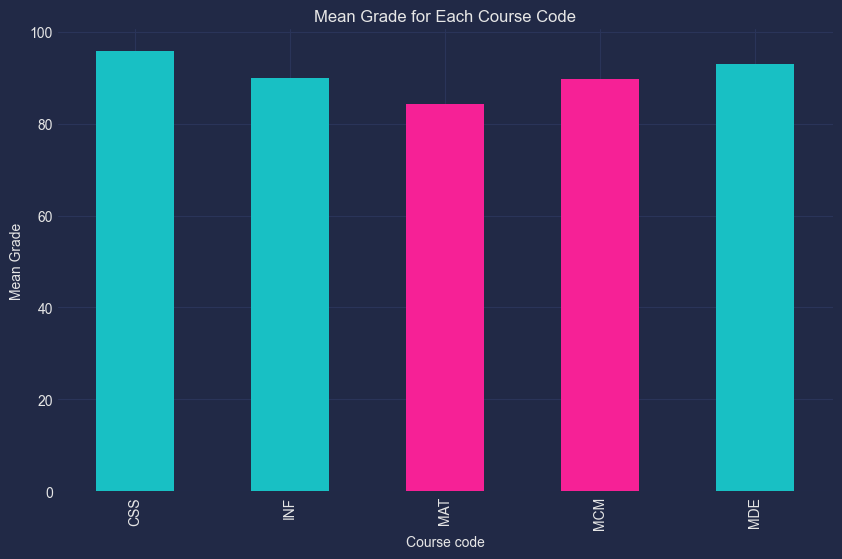

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already defined transcript_import function
from transcript import transcript_import

# Given chat_id
# chat_id = "767413484"
df = transcript_import(chat_id)
df["Course code"] = df["Course code"].str.extract(r"^(\w+)")

# Use the specified stylesheet
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
)

# Accessing the default colors from the style
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Calculate the mean grade for each unique course code
mean_grades = df.groupby("Course code")["Grade"].mean()

# Define colors using default colors
colors = [
    default_colors[0] if grade >= mean_grades.median() else default_colors[1]
    for grade in mean_grades
]

# Plotting
plt.figure(figsize=(10, 6))
mean_grades.plot(kind="bar", color=colors)
plt.xlabel("Course code")
plt.ylabel("Mean Grade")
plt.title("Mean Grade for Each Course Code")
plt.grid(True)  # Add grid
plt.show()

In [9]:
# Assuming df is your DataFrame
# Assuming df is your DataFrame
df["Course code"] = df["Course code"].str.split(" ")
df

AttributeError: Can only use .str accessor with string values!